## TP parte A - Ruleta, Crossover Mutacion

### Librerias

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Variables

In [149]:
PROB_CROSSOVER = 0.75
PROB_MUTACION = 0.05
CICLOS = 200
CANTIDAD_POBLACION = 10
COEF = 1073741823
ITERACIONES_IMPRIMIBLES = [20, 100, 200]

### Fitness y Objetivo

In [150]:
def convertirPoblacion(pob_ini, bin=True): # Pasar False para convertir a decimal
    pob_fin = []
    for numero in pob_ini:
        if bin:
            pob_fin.append(format(numero,'030b'))
        else:
            pob_fin.append(int(str(numero), 2))
    return pob_fin

In [151]:
def funcionObjetivo(poblacion_binarios, coeficiente):
    poblacion = convertirPoblacion(poblacion_binarios, False)
    fun_objetivo = []
    for cromosoma in poblacion:
        fun_objetivo.append((cromosoma/coeficiente)**2)
    return fun_objetivo

In [152]:
def funcionFitness(poblacion_binarios, coeficiente):
    fitness = []
    fun_objetivo = funcionObjetivo(poblacion_binarios, coeficiente)
    for objetivo in fun_objetivo:
        fitness.append((objetivo/sum(fun_objetivo)))
    return fitness

#### Poblacion

In [153]:
def poblacionInicial():
  rng = np.random.default_rng() # Random Number Generator
  poblacion_decimal = rng.integers(low=0, high=COEF, size=CANTIDAD_POBLACION)
  return poblacion_decimal
poblacion_decimal = poblacionInicial()
poblacion_decimal

array([ 76666594, 584171019, 857267090, 539778960, 262496784, 142861506,
       660640341, 896742859, 849140302,  93858671], dtype=int64)

#### Binarios

In [154]:
poblacion_binarios = convertirPoblacion(poblacionInicial(), True)
poblacion_binarios

['110111011010101010000010100111',
 '010010100111000110001110000100',
 '000000110010110010000100000111',
 '001101001001001011101000010100',
 '111100111000111101010111101100',
 '111010001110111000111001011011',
 '100110101100001000001011100000',
 '001010001101001101100100001011',
 '000110010001000011101101001101',
 '111110001110101100111001111011']

### Tabla de datos

In [155]:
def generarDataFrame(pob_bin, coeficiente):
    pob_dec = convertirPoblacion(pob_bin, False)
    data = {'Decimales': pob_dec, 'Binarios': pob_bin, 
            'FuncionObjetivo':np.array(funcionObjetivo(pob_bin,coeficiente))}
    data_frame = pd.DataFrame(data)
    data_frame['Fitness'] = np.array(funcionFitness(pob_bin, coeficiente))
    return data_frame
data_frame = generarDataFrame(poblacion_binarios, COEF)
data_frame

,Decimales,Binarios,FuncionObjetivo,Fitness
0,929734823,110111011010101010000010100111,0.749753,0.189541
1,312238980,010010100111000110001110000100,0.084562,0.021378
2,13312263,000000110010110010000100000111,0.000154,0.000039
3,220510740,001101001001001011101000010100,0.042175,0.010662
4,1021564396,111100111000111101010111101100,0.905173,0.228832
5,976981595,111010001110111000111001011011,0.827891,0.209295
6,649102048,100110101100001000001011100000,0.365449,0.092387
7,171235595,001010001101001101100100001011,0.025432,0.006429
8,105134925,000110010001000011101101001101,0.009587,0.002424
9,1044041339,111110001110101100111001111011,0.945444,0.239013


#### Estadisticas Marco de datos

In [156]:
def generarEstadisticas(dataFrame):
    stats = {'Suma':[ dataFrame['FuncionObjetivo'].sum(), dataFrame['Fitness'].sum() ],
                'Promedio': [ dataFrame['FuncionObjetivo'].mean(), dataFrame['Fitness'].mean() ],
                'Máximo': [ dataFrame['FuncionObjetivo'].max(), dataFrame['Fitness'].max() ], 
                'Mínimo': [ dataFrame['FuncionObjetivo'].min(), dataFrame['Fitness'].min() ]}
    dataFrame_stats = pd.DataFrame(stats, index = ['Función objetivo', 'Fitness'])
    return dataFrame_stats, stats
marcoDeDatos_stats, stats = generarEstadisticas(data_frame)
mc = marcoDeDatos_stats.loc['Fitness']
mc

Suma        1.000000
Promedio    0.100000
Máximo      0.239013
Mínimo      0.000039
Name: Fitness, dtype: float64

### Ruleta

In [157]:
def ruleta(pob_bin, coeficiente, cantidad_poblacion):
    # Asigna probabilidad basada en el fitness
    cromosomas = np.array(pob_bin)
    probabilidades = np.array(funcionFitness(pob_bin, coeficiente))
    np.random.seed()
    binarios_ruleta = np.random.choice(cromosomas, size=int(cantidad_poblacion), p=probabilidades)
    binarios_ruleta = binarios_ruleta.tolist()
    return binarios_ruleta
#binarios_ruleta = ruleta(poblacion_binarios, COEF)
#binarios_ruleta

### Crossover

In [158]:
def crossover(poblacion_binarios, prob_corssover):
    hijos_crossover = []
    pob_binarios = np.array(poblacion_binarios)
    cantidad_poblacion = len(pob_binarios)
    genes = len(pob_binarios[0])
    for i in range(0, cantidad_poblacion, 2):
        opciones = [True, False]
        np.random.seed()
        # Probabilidades de cada opción
        prob_cross = np.array([prob_corssover, (1-prob_corssover)])
        cross = np.random.choice(opciones, size=1, p=prob_cross)
        if cross[0]:
            posiciones = [x for x in range(0, genes)]
            probCorte = [(1/genes) for x in range(0, genes)]
            # Devuelve ndarray de 1 elemento
            corte = np.random.choice(posiciones, size=1, p=probCorte)
            posicionCorte = corte[0]
            primerTiraGenesPadre1 = pob_binarios[i][0:posicionCorte]
            segundaTiraGenesPadre1 = pob_binarios[i][posicionCorte:genes]
            primerTiraGenesPadre2 = pob_binarios[i+1][0:posicionCorte]
            segundaTiraGenesPadre2 = pob_binarios[i+1][posicionCorte:genes]
            hijos_crossover.append(primerTiraGenesPadre1 + segundaTiraGenesPadre2)  # Hijo 1
            hijos_crossover.append(primerTiraGenesPadre2 + segundaTiraGenesPadre1)  # Hijo 2
        else:
            hijos_crossover.append(pob_binarios[i])
            hijos_crossover.append(pob_binarios[i+1])
    return hijos_crossover
#binarios_crossover = crossover(binarios_ruleta, PROB_CROSSOVER)
#binarios_crossover

### Mutacion

In [159]:
def mutacion(hijos_binarios, prob_mutacion):
        hijos_mutados = []
        genes = len(str(hijos_binarios[0]))
        for hijo in hijos_binarios:
            opciones = [True, False]
            np.random.seed()
            # Probabilidades de cada opción
            prob_mut = np.array([prob_mutacion, (1-prob_mutacion)])
            mut = np.random.choice(opciones, size=1, p=prob_mut)
            if mut[0]:
                posiciones = [x for x in range(0, genes)]
                probMutacion = [1/genes for x in range(0, genes)]
                # Devuelve ndarray de 1 elemento
                posicionMutacion = np.random.choice(posiciones, size=1, p=probMutacion)
                posicionMutacion = posicionMutacion[0]
                if hijo[posicionMutacion] == '0':
                    hijo = hijo[:posicionMutacion] + '1' + hijo[posicionMutacion+1:]
                else:
                    hijo = hijo[:posicionMutacion] + '0' + hijo[posicionMutacion+1:]
            hijos_mutados.append(hijo)
        return hijos_mutados
#mutados = mutacion(binarios_crossover, PROB_MUTACION)
#mutados

### Torneo

In [160]:
def torneo(poblacion_binarios, coeficiente, cantidad_poblacion):
    binarios_torneo = []
    pob_binarios = np.array(poblacion_binarios)
    fitness = np.array(funcionFitness(pob_binarios, coeficiente))
    for i in range(0, cantidad_poblacion):
        posiblesCantidades = [x for x in range(1, (cantidad_poblacion+1))]
        np.random.seed()
        cantidadMiembrosTorneo = np.random.choice(posiblesCantidades, size=1)
        # Trabaja directamente con los fitness de los cromósomas
        miembrosTorneo = np.random.choice(fitness, size=cantidadMiembrosTorneo[0], replace=False)
        ganador = np.amax(miembrosTorneo)
        indiceGanador = np.where(fitness == ganador)  # retorna ndarray
        cromosomaGanador = pob_binarios[indiceGanador[0][0]]
        binarios_torneo.append(cromosomaGanador)
    return binarios_torneo
#binarios_torneo = torneo(poblacion_binarios, COEF)
#binarios_torneo

### Elitismo

In [161]:
def elitismo(poblacion_binarios, cantidad, coeficiente):
    fitness = funcionFitness(poblacion_binarios, coeficiente)
    elites = []
    for i in range(0, cantidad):
        ganador = max(fitness)
        indiceGanador = fitness.index(ganador)
        cromosomaGanador = poblacion_binarios[indiceGanador]
        elites.append(cromosomaGanador)
        fitness.remove(ganador)
    return elites
#elites = elitismo(poblacion_binarios, 2, COEF)
#elites

## Iteracion

### Tablas

In [162]:
def hacerTabla(cantIteraciones, maximos, minimos, promedios):
    iteraciones = [x for x in range(1,cantIteraciones+1)]
    data = {'Iteracion': iteraciones, 'Maximo': maximos, 
            'Minimo':minimos, 'Promedio':promedios}
    data_frame = pd.DataFrame(data)
    return data_frame

### Graficos

In [163]:
def hacerGrafico(estadisticas, iteracion):
    estadisticas["Iteración"]=[x for x in range(1,iteracion+1)]
    plt.figure(figsize=(20,20))
    plt.plot(estadisticas["Iteración"], estadisticas["Máximo"], 'b.-', label="Máximo")
    plt.plot(estadisticas["Iteración"], estadisticas["Mínimo"], 'r.-', label="Mínimo")
    plt.plot(estadisticas["Iteración"], estadisticas["Promedio"], 'g.-', label="Promedio")
    plt.legend()
    plt.title("Gráfica iteración: " + str(iteracion))
    plt.xticks(estadisticas["Iteración"][::1])
    plt.yticks(np.arange(0, 1.01, step=0.025))
    plt.xlabel("Iteraciones")
    plt.ylabel("F. Objetivo")
    plt.show()

### Iteracion

CASO A: Método selección ruleta


Iteracion,Maximo,Minimo,Promedio
1,0.863574,0.000742,0.422202
2,0.863573,0.002082,0.615819
3,0.863573,0.391340,0.699030
4,0.862692,0.391645,0.742252
5,0.862692,0.391345,0.739775
6,0.862694,0.142001,0.641289
7,0.822333,0.391345,0.737367
8,0.822333,0.736991,0.772230
9,0.822325,0.765778,0.772846
10,0.822333,0.765802,0.778504


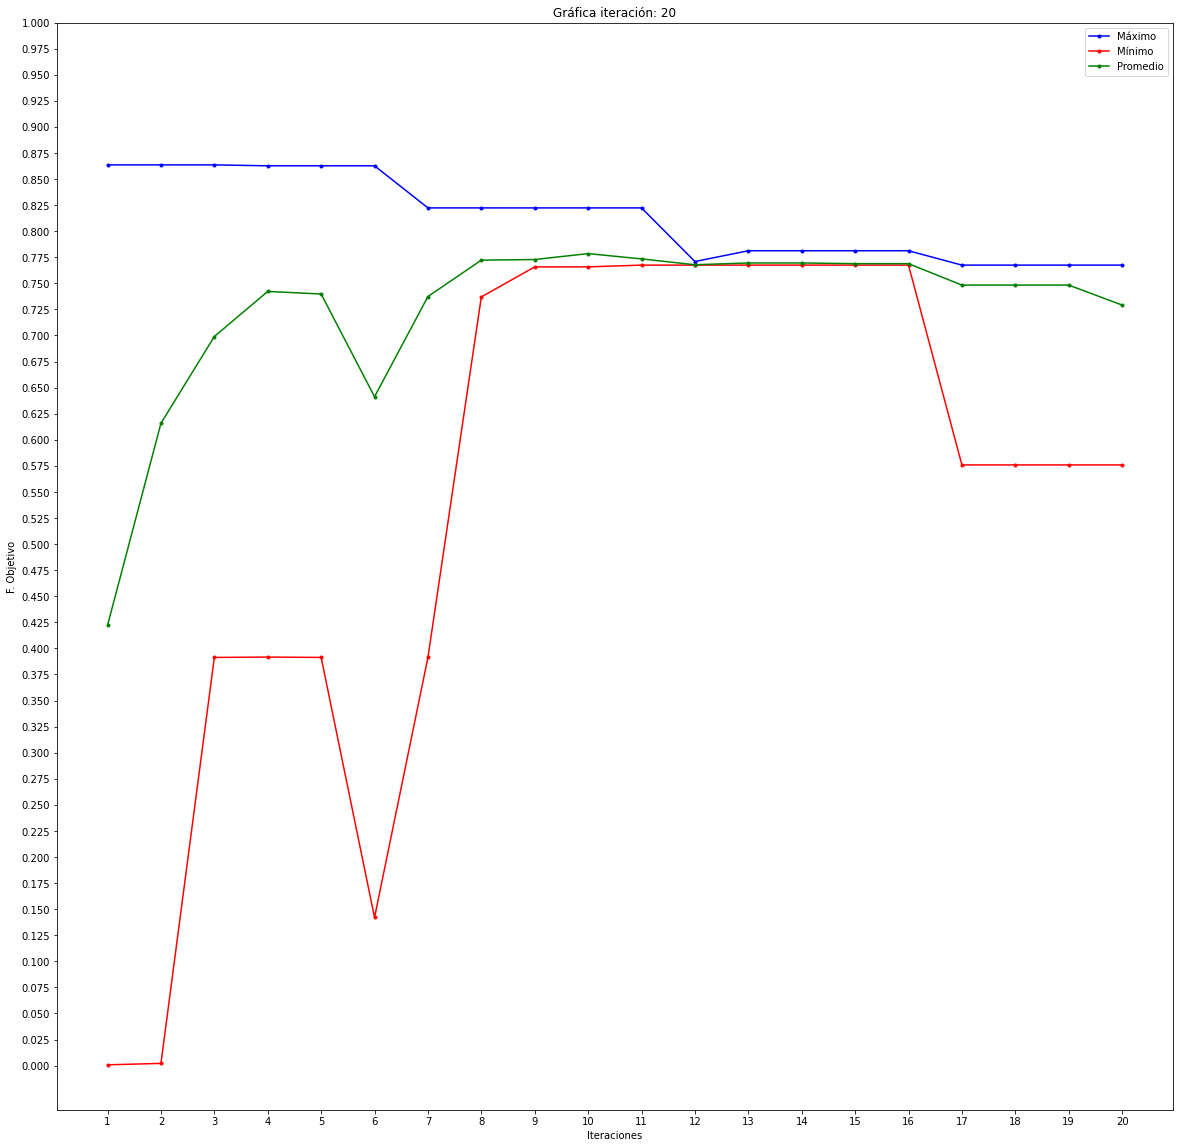

Iteracion,Maximo,Minimo,Promedio
1,0.863574,0.000742,0.422202
2,0.863573,0.002082,0.615819
3,0.863573,0.391340,0.699030
4,0.862692,0.391645,0.742252
5,0.862692,0.391345,0.739775
6,0.862694,0.142001,0.641289
7,0.822333,0.391345,0.737367
8,0.822333,0.736991,0.772230
9,0.822325,0.765778,0.772846
10,0.822333,0.765802,0.778504


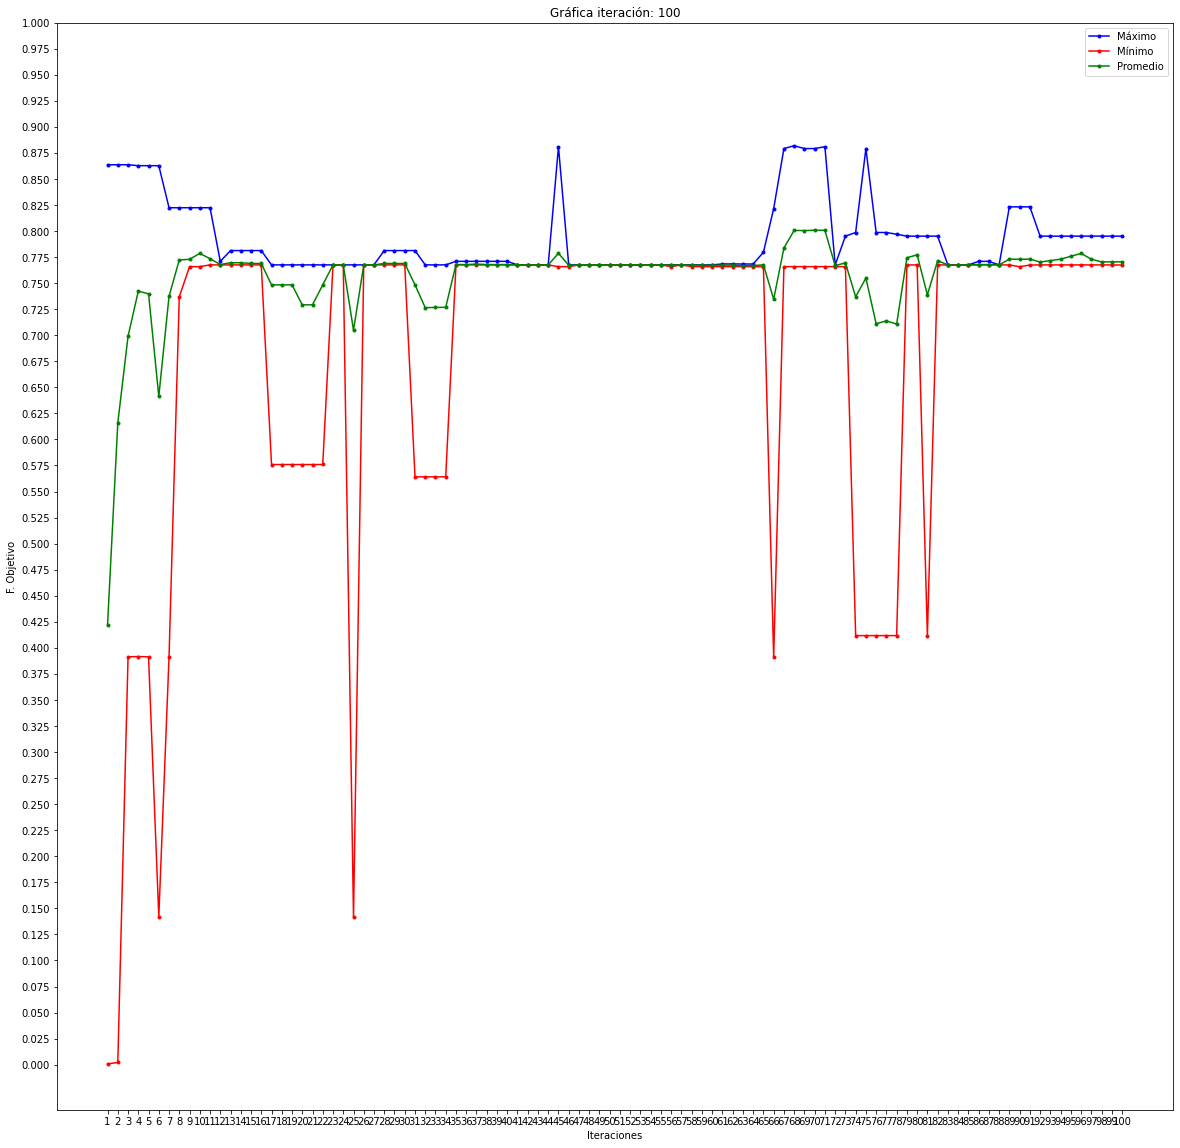

Iteracion,Maximo,Minimo,Promedio
1,0.863574,0.000742,0.422202
2,0.863573,0.002082,0.615819
3,0.863573,0.391340,0.699030
4,0.862692,0.391645,0.742252
5,0.862692,0.391345,0.739775
6,0.862694,0.142001,0.641289
7,0.822333,0.391345,0.737367
8,0.822333,0.736991,0.772230
9,0.822325,0.765778,0.772846
10,0.822333,0.765802,0.778504


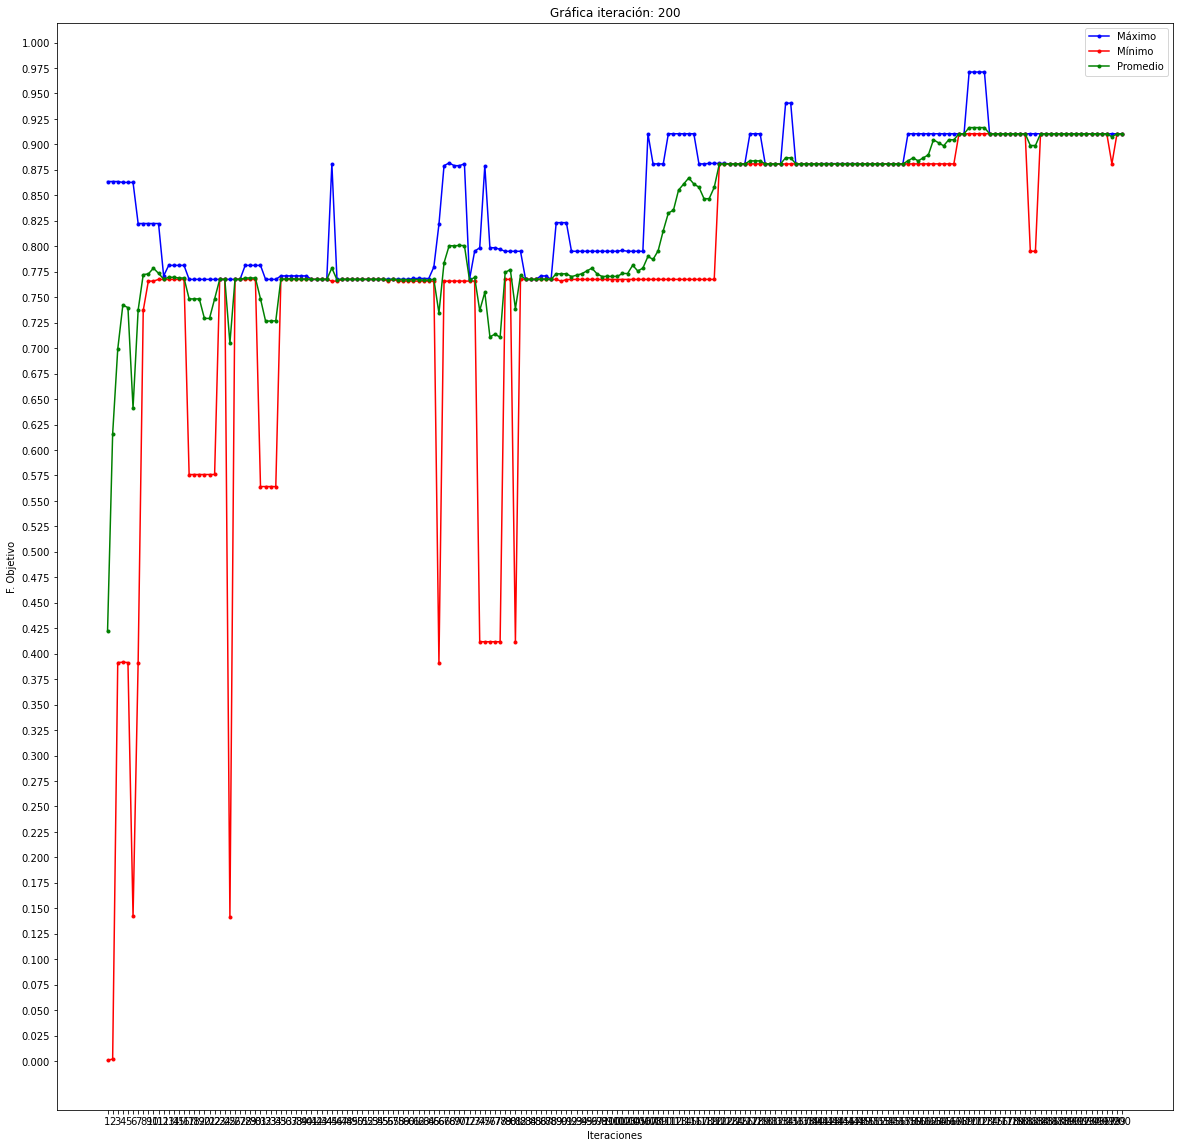

CASO B: Método selección torneo


Iteracion,Maximo,Minimo,Promedio
1,0.821304,0.033189,0.337979
2,0.821321,0.678546,0.807030
3,0.821321,0.821304,0.821315
4,0.821332,0.821294,0.821320
5,0.822207,0.821321,0.821414
6,0.822207,0.821321,0.821505
7,0.822207,0.821332,0.821945
8,0.822209,0.821332,0.822119
9,0.822209,0.822207,0.822208
10,0.822209,0.822207,0.822209


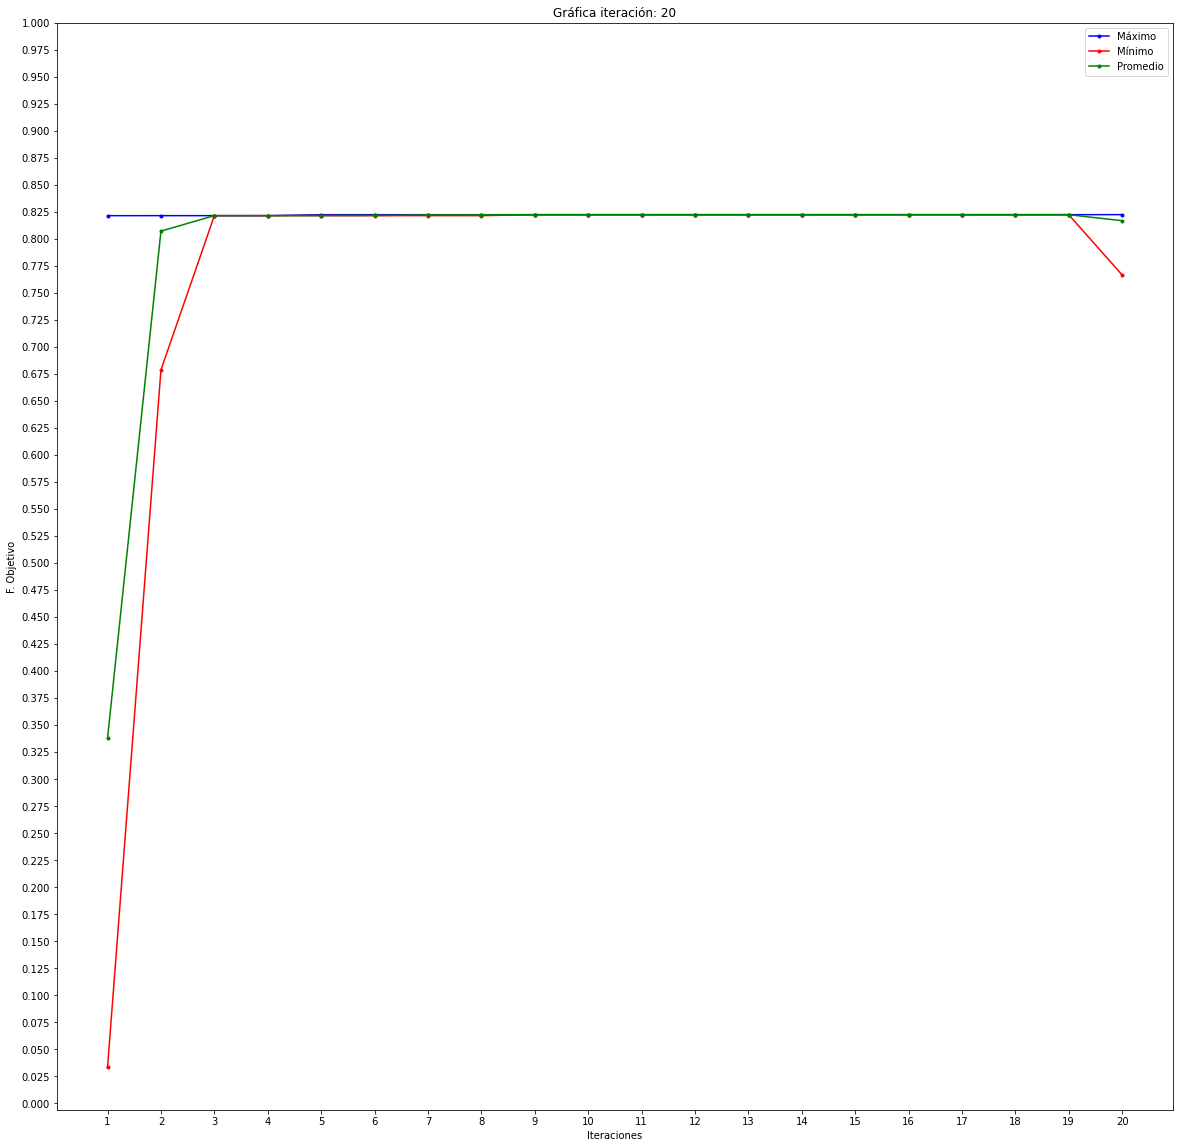

Iteracion,Maximo,Minimo,Promedio
1,0.821304,0.033189,0.337979
2,0.821321,0.678546,0.807030
3,0.821321,0.821304,0.821315
4,0.821332,0.821294,0.821320
5,0.822207,0.821321,0.821414
6,0.822207,0.821321,0.821505
7,0.822207,0.821332,0.821945
8,0.822209,0.821332,0.822119
9,0.822209,0.822207,0.822208
10,0.822209,0.822207,0.822209


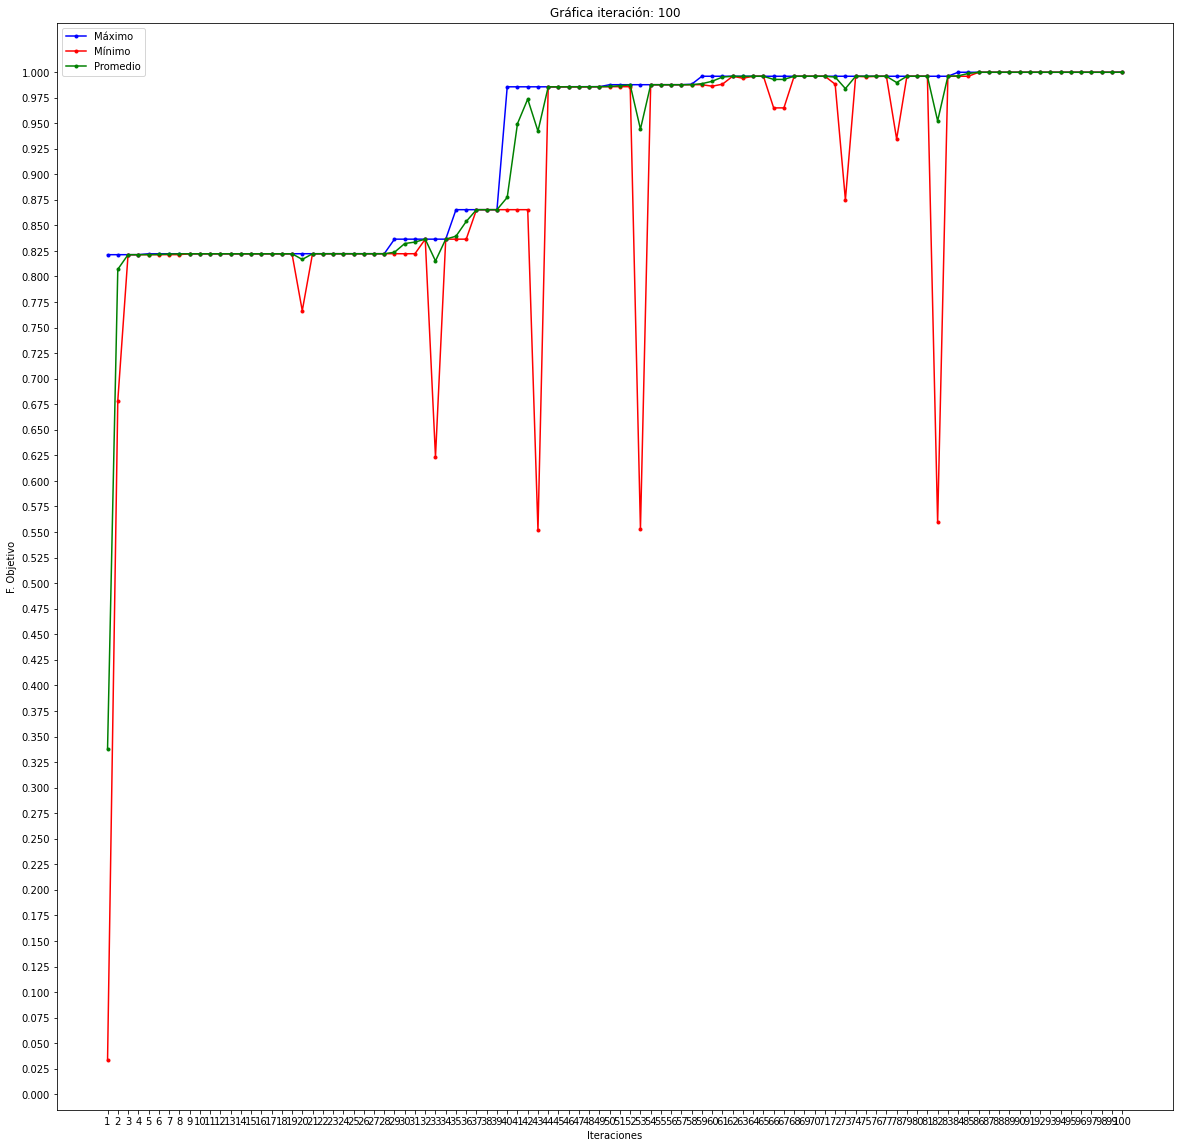

Iteracion,Maximo,Minimo,Promedio
1,0.821304,0.033189,0.337979
2,0.821321,0.678546,0.807030
3,0.821321,0.821304,0.821315
4,0.821332,0.821294,0.821320
5,0.822207,0.821321,0.821414
6,0.822207,0.821321,0.821505
7,0.822207,0.821332,0.821945
8,0.822209,0.821332,0.822119
9,0.822209,0.822207,0.822208
10,0.822209,0.822207,0.822209


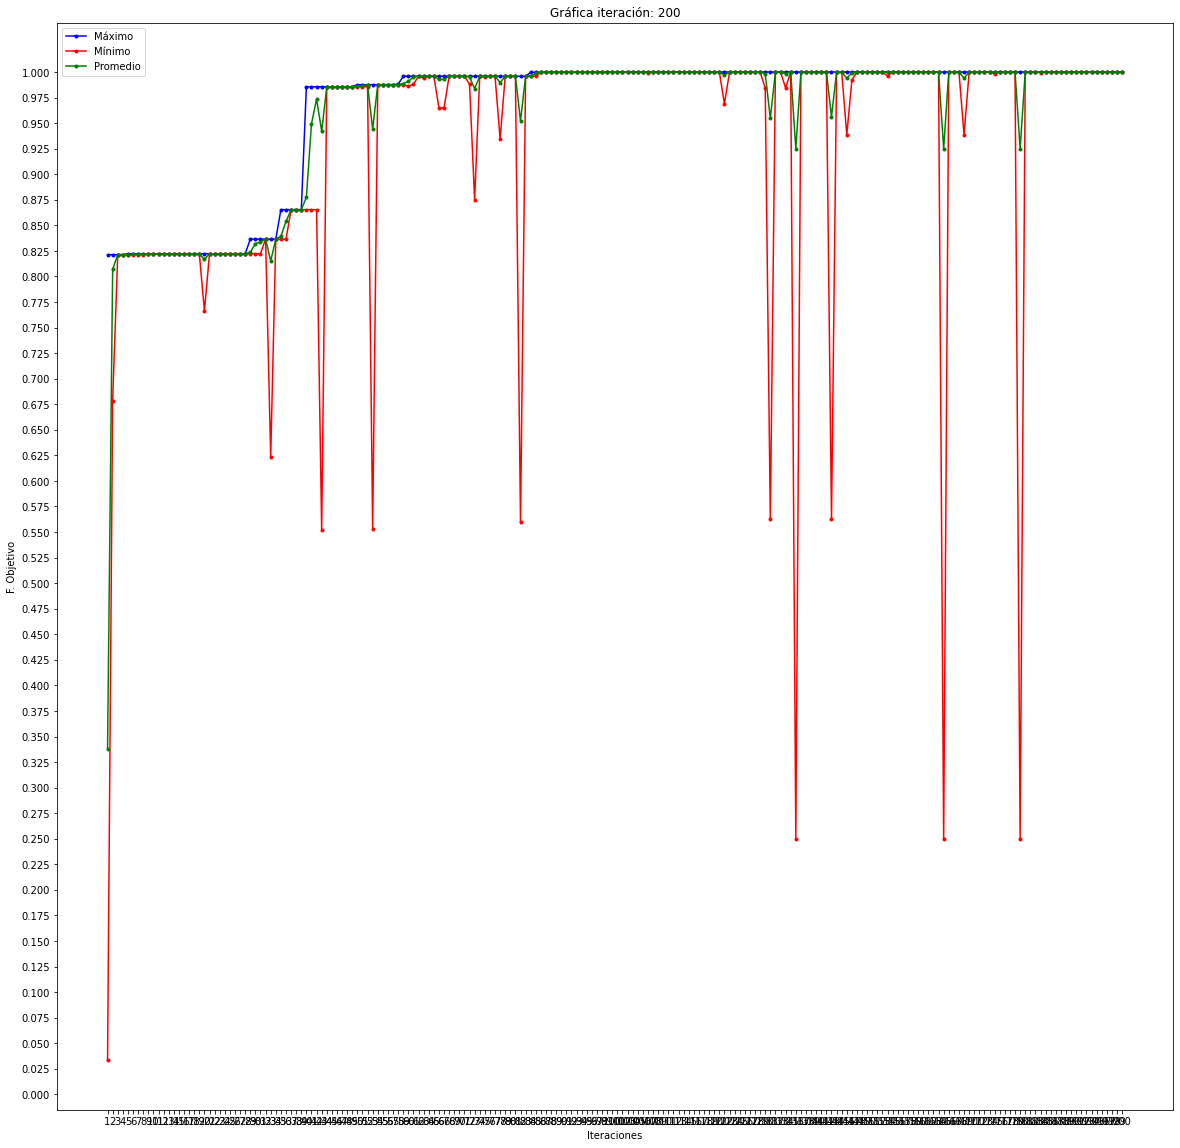

CASO C: Método selección Ruleta con elitismo


Iteracion,Maximo,Minimo,Promedio
1,0.990314,0.033491,0.538533
2,0.992200,0.033491,0.845982
3,0.992200,0.866188,0.948164
4,0.992200,0.900956,0.973008
5,0.992200,0.886186,0.971531
6,0.992200,0.990314,0.991257
7,0.992200,0.990314,0.991257
8,0.992200,0.990314,0.991633
9,0.992201,0.930921,0.985695
10,0.992201,0.930921,0.979756


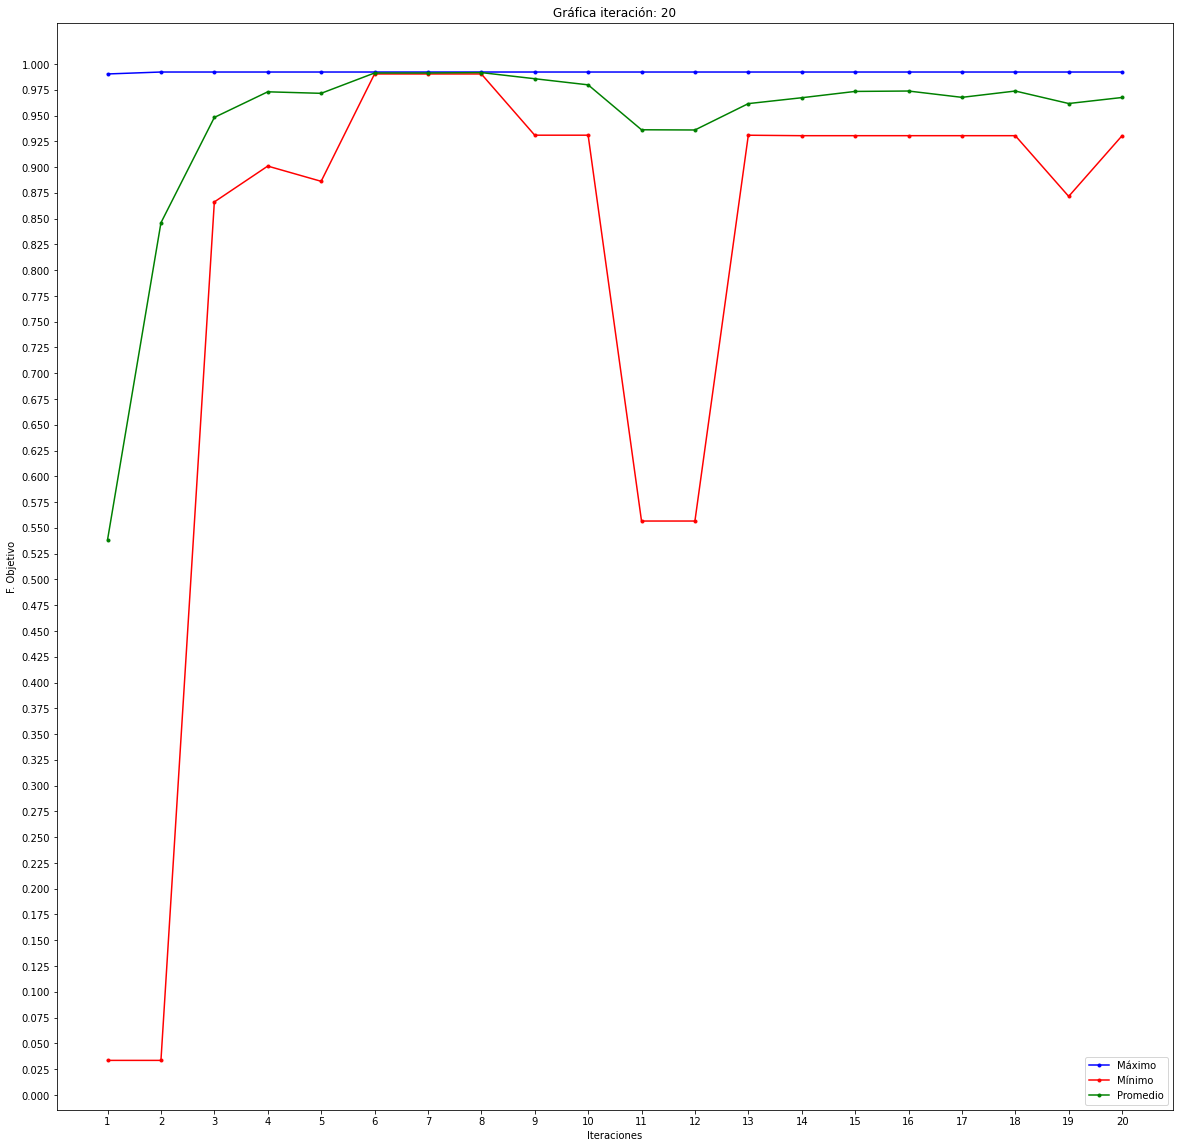

Iteracion,Maximo,Minimo,Promedio
1,0.990314,0.033491,0.538533
2,0.992200,0.033491,0.845982
3,0.992200,0.866188,0.948164
4,0.992200,0.900956,0.973008
5,0.992200,0.886186,0.971531
6,0.992200,0.990314,0.991257
7,0.992200,0.990314,0.991257
8,0.992200,0.990314,0.991633
9,0.992201,0.930921,0.985695
10,0.992201,0.930921,0.979756


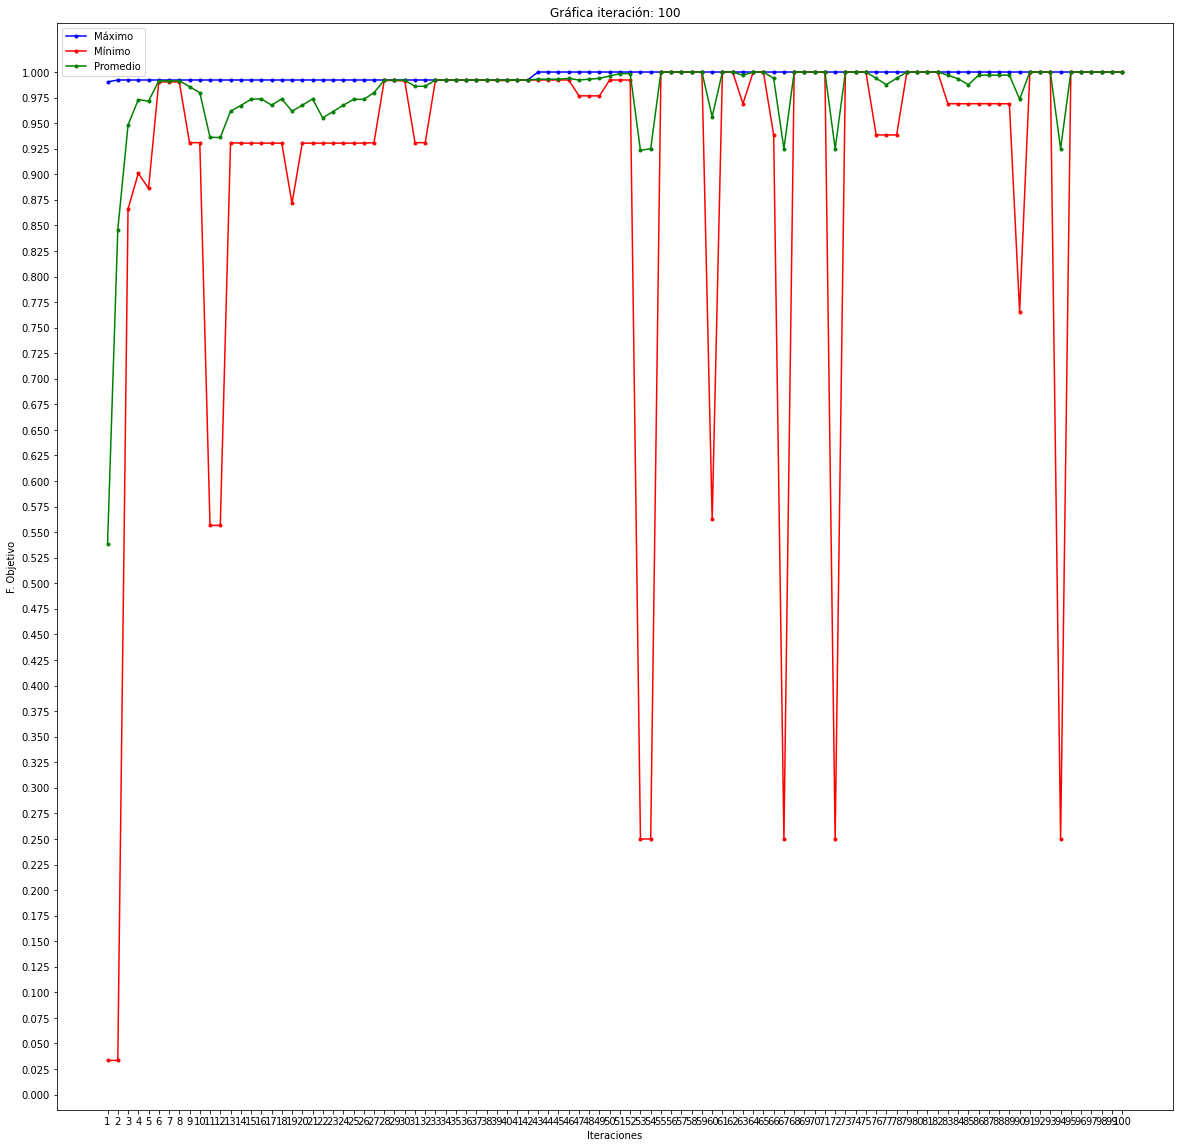

Iteracion,Maximo,Minimo,Promedio
1,0.990314,0.033491,0.538533
2,0.992200,0.033491,0.845982
3,0.992200,0.866188,0.948164
4,0.992200,0.900956,0.973008
5,0.992200,0.886186,0.971531
6,0.992200,0.990314,0.991257
7,0.992200,0.990314,0.991257
8,0.992200,0.990314,0.991633
9,0.992201,0.930921,0.985695
10,0.992201,0.930921,0.979756


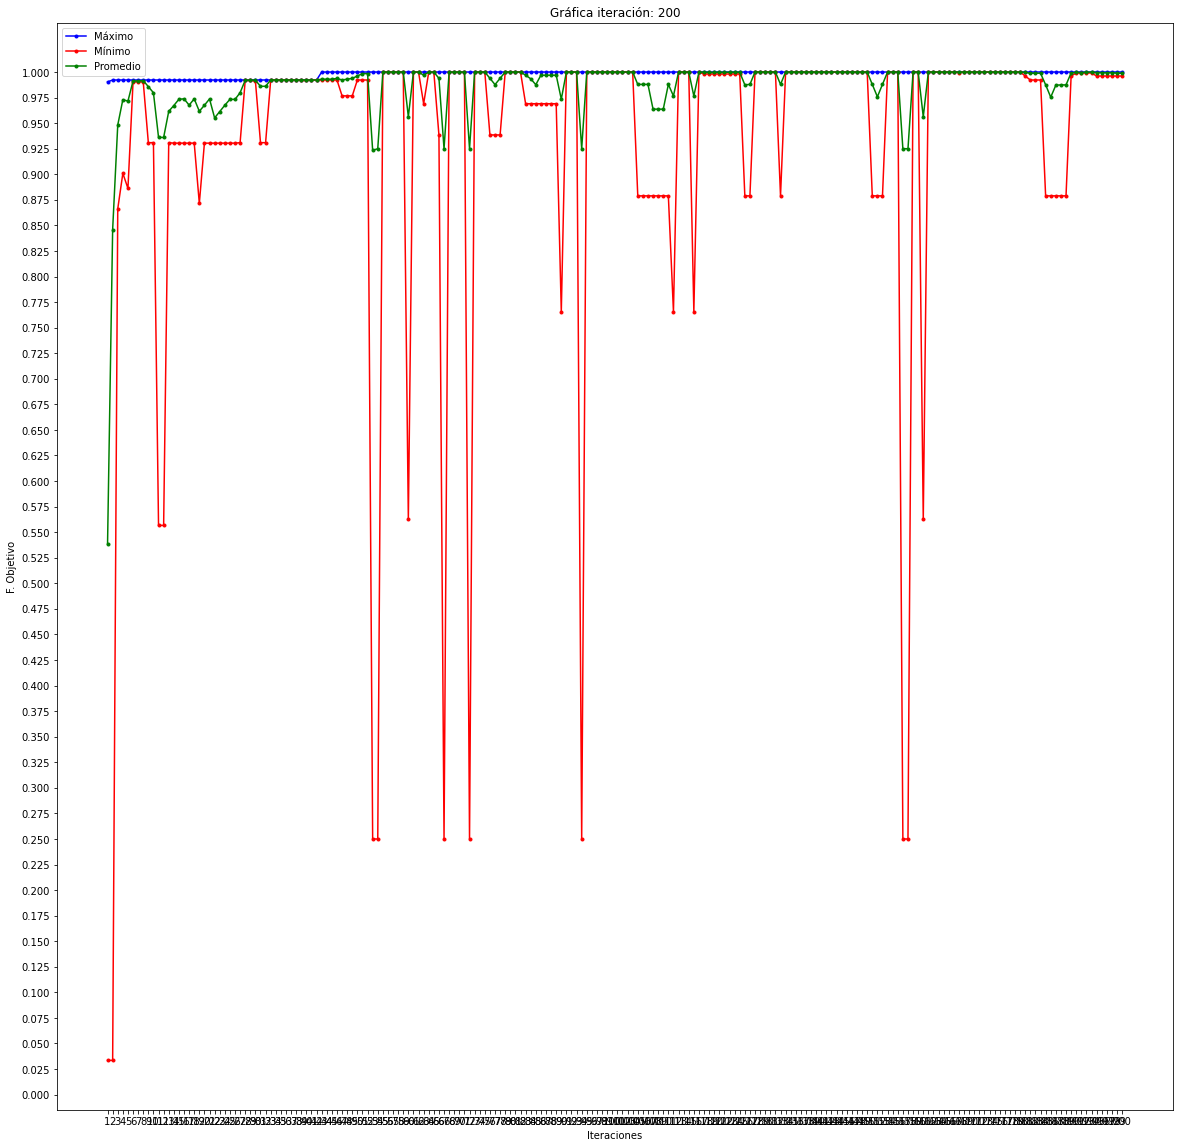

CASO C: Método selección torneo con elitismo


Iteracion,Maximo,Minimo,Promedio
1,0.761720,0.002149,0.281864
2,0.761720,0.024721,0.574774
3,0.761773,0.036203,0.689174
4,0.761773,0.761720,0.761731
5,0.761773,0.748197,0.760400
6,0.761773,0.760070,0.761603
7,0.761773,0.761773,0.761773
8,0.761773,0.761773,0.761773
9,0.761773,0.761773,0.761773
10,0.761773,0.761773,0.761773


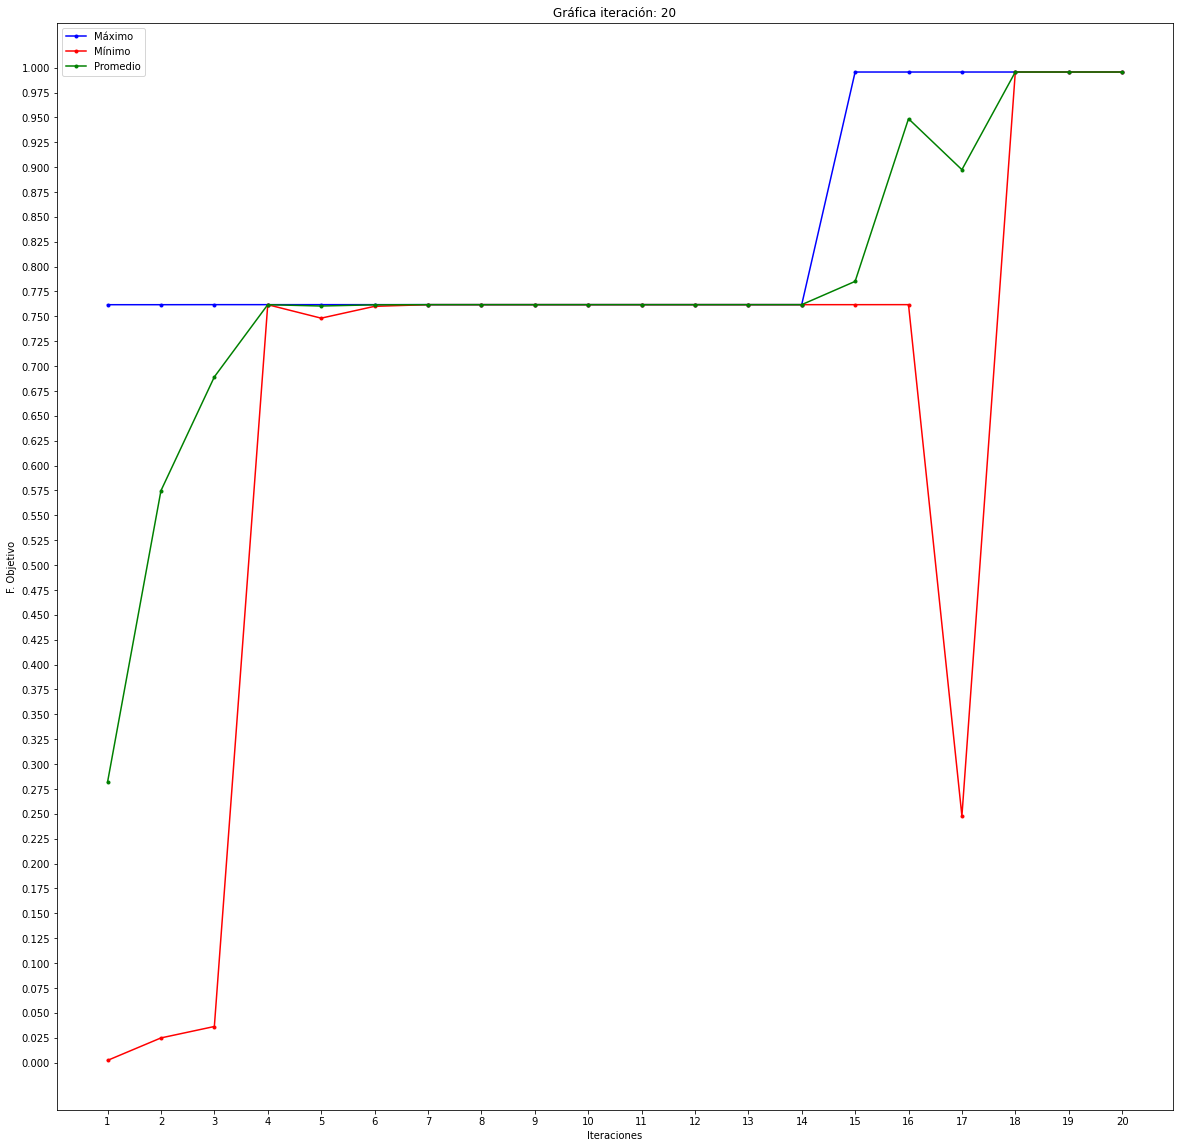

Iteracion,Maximo,Minimo,Promedio
1,0.761720,0.002149,0.281864
2,0.761720,0.024721,0.574774
3,0.761773,0.036203,0.689174
4,0.761773,0.761720,0.761731
5,0.761773,0.748197,0.760400
6,0.761773,0.760070,0.761603
7,0.761773,0.761773,0.761773
8,0.761773,0.761773,0.761773
9,0.761773,0.761773,0.761773
10,0.761773,0.761773,0.761773


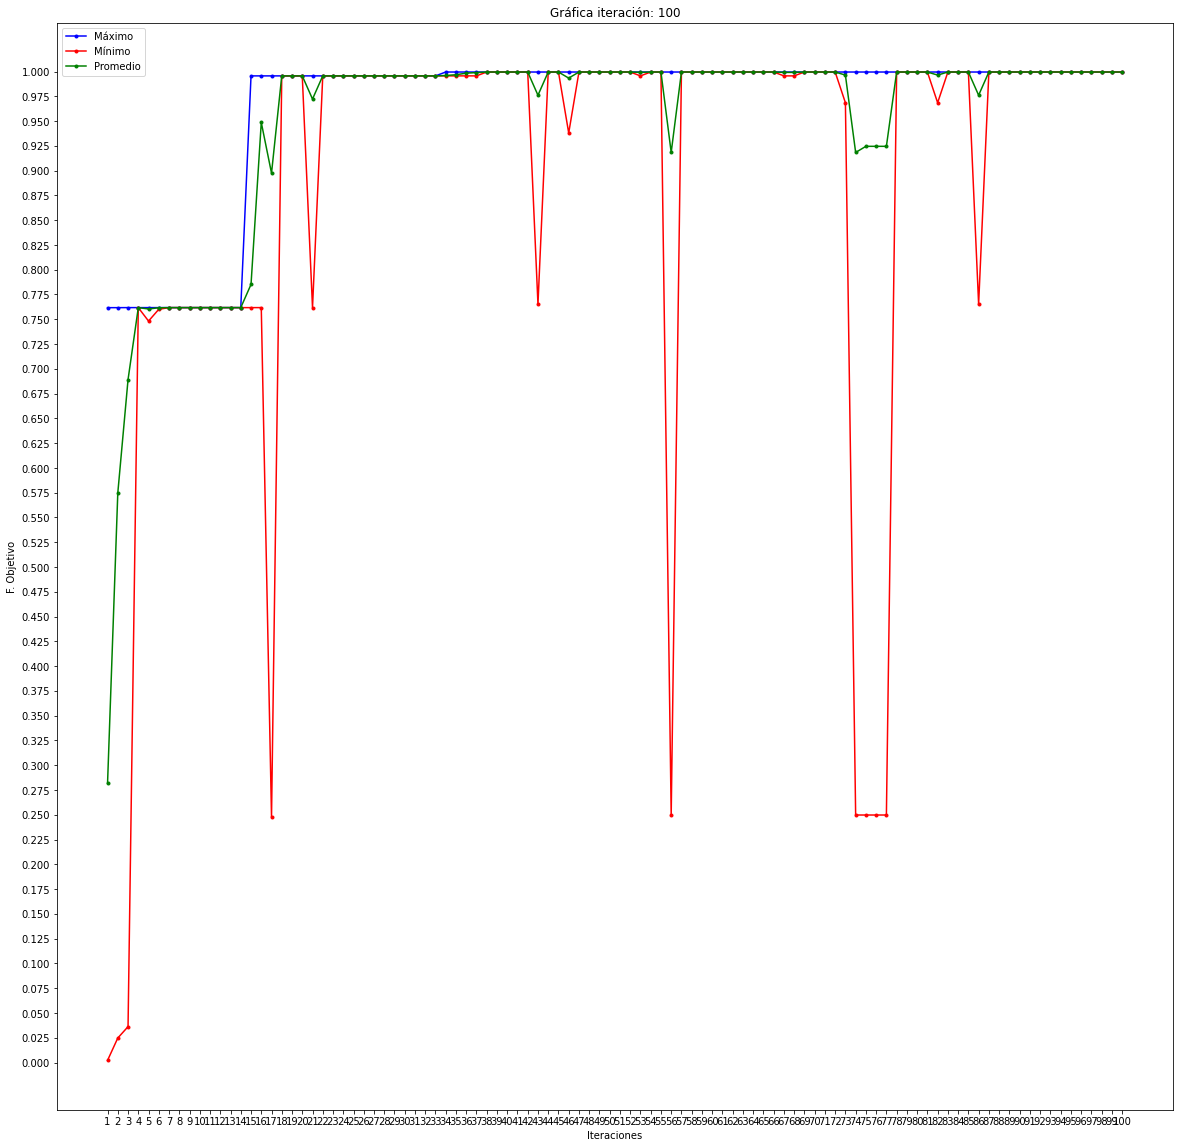

Iteracion,Maximo,Minimo,Promedio
1,0.761720,0.002149,0.281864
2,0.761720,0.024721,0.574774
3,0.761773,0.036203,0.689174
4,0.761773,0.761720,0.761731
5,0.761773,0.748197,0.760400
6,0.761773,0.760070,0.761603
7,0.761773,0.761773,0.761773
8,0.761773,0.761773,0.761773
9,0.761773,0.761773,0.761773
10,0.761773,0.761773,0.761773


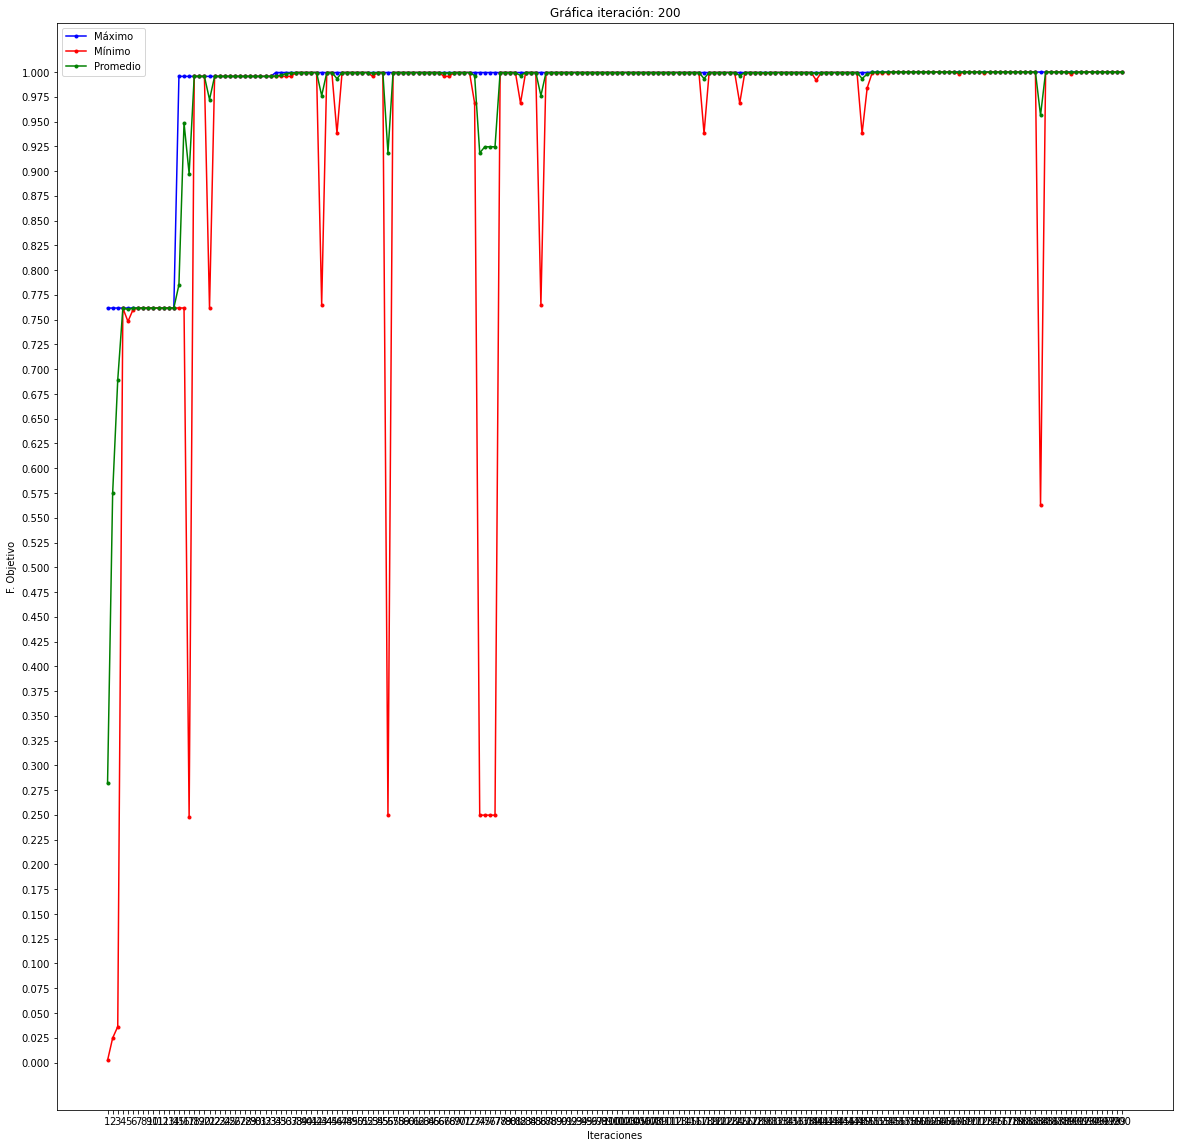

-----------------Sin mutación-----------------
CASO A: Método selección ruleta sin mutación


Iteracion,Maximo,Minimo,Promedio
1,0.977915,0.005864,0.632419
2,0.977915,0.665643,0.776410
3,0.977915,0.665478,0.756111
4,0.977909,0.665478,0.733541
5,0.977909,0.665478,0.764751
6,0.977912,0.665475,0.795979
7,0.977912,0.665478,0.800302
8,0.977912,0.665478,0.820271
9,0.977912,0.665478,0.889665
10,0.979301,0.719561,0.951967


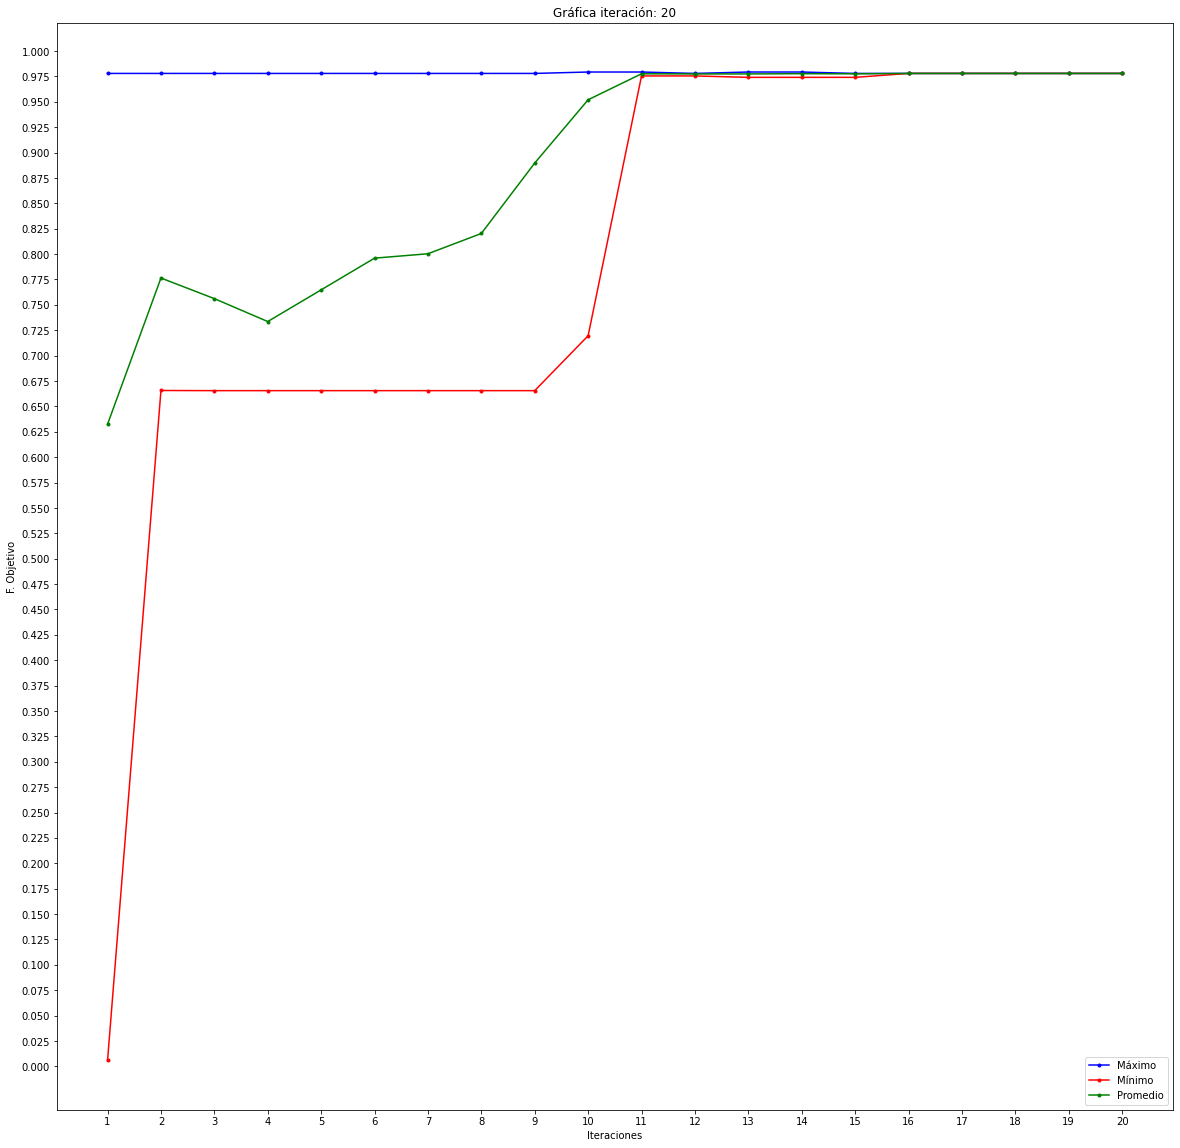

Iteracion,Maximo,Minimo,Promedio
1,0.977915,0.005864,0.632419
2,0.977915,0.665643,0.776410
3,0.977915,0.665478,0.756111
4,0.977909,0.665478,0.733541
5,0.977909,0.665478,0.764751
6,0.977912,0.665475,0.795979
7,0.977912,0.665478,0.800302
8,0.977912,0.665478,0.820271
9,0.977912,0.665478,0.889665
10,0.979301,0.719561,0.951967


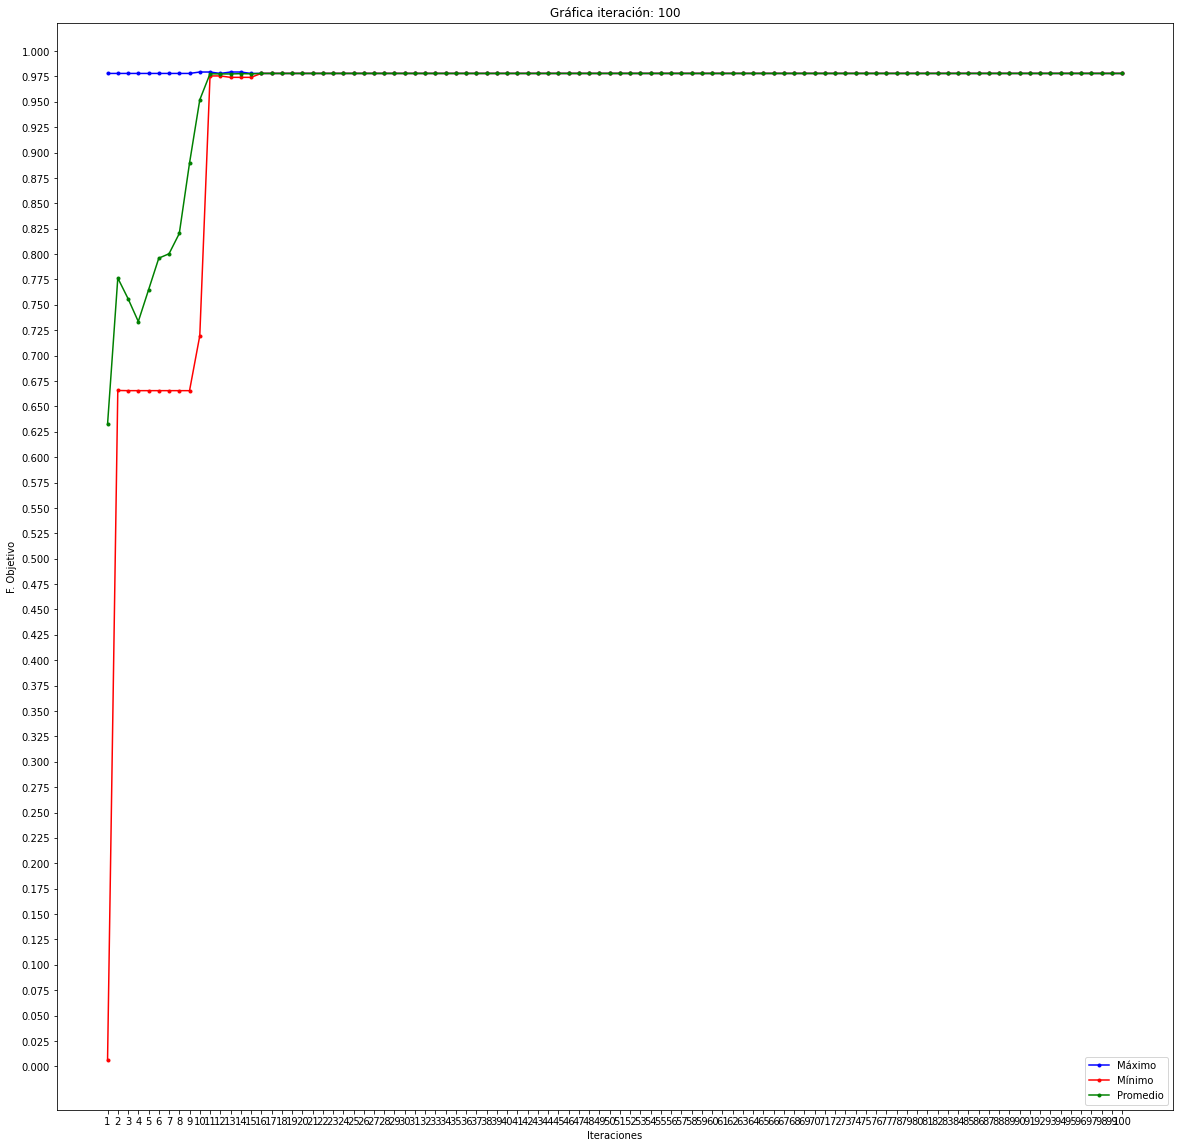

Iteracion,Maximo,Minimo,Promedio
1,0.977915,0.005864,0.632419
2,0.977915,0.665643,0.776410
3,0.977915,0.665478,0.756111
4,0.977909,0.665478,0.733541
5,0.977909,0.665478,0.764751
6,0.977912,0.665475,0.795979
7,0.977912,0.665478,0.800302
8,0.977912,0.665478,0.820271
9,0.977912,0.665478,0.889665
10,0.979301,0.719561,0.951967


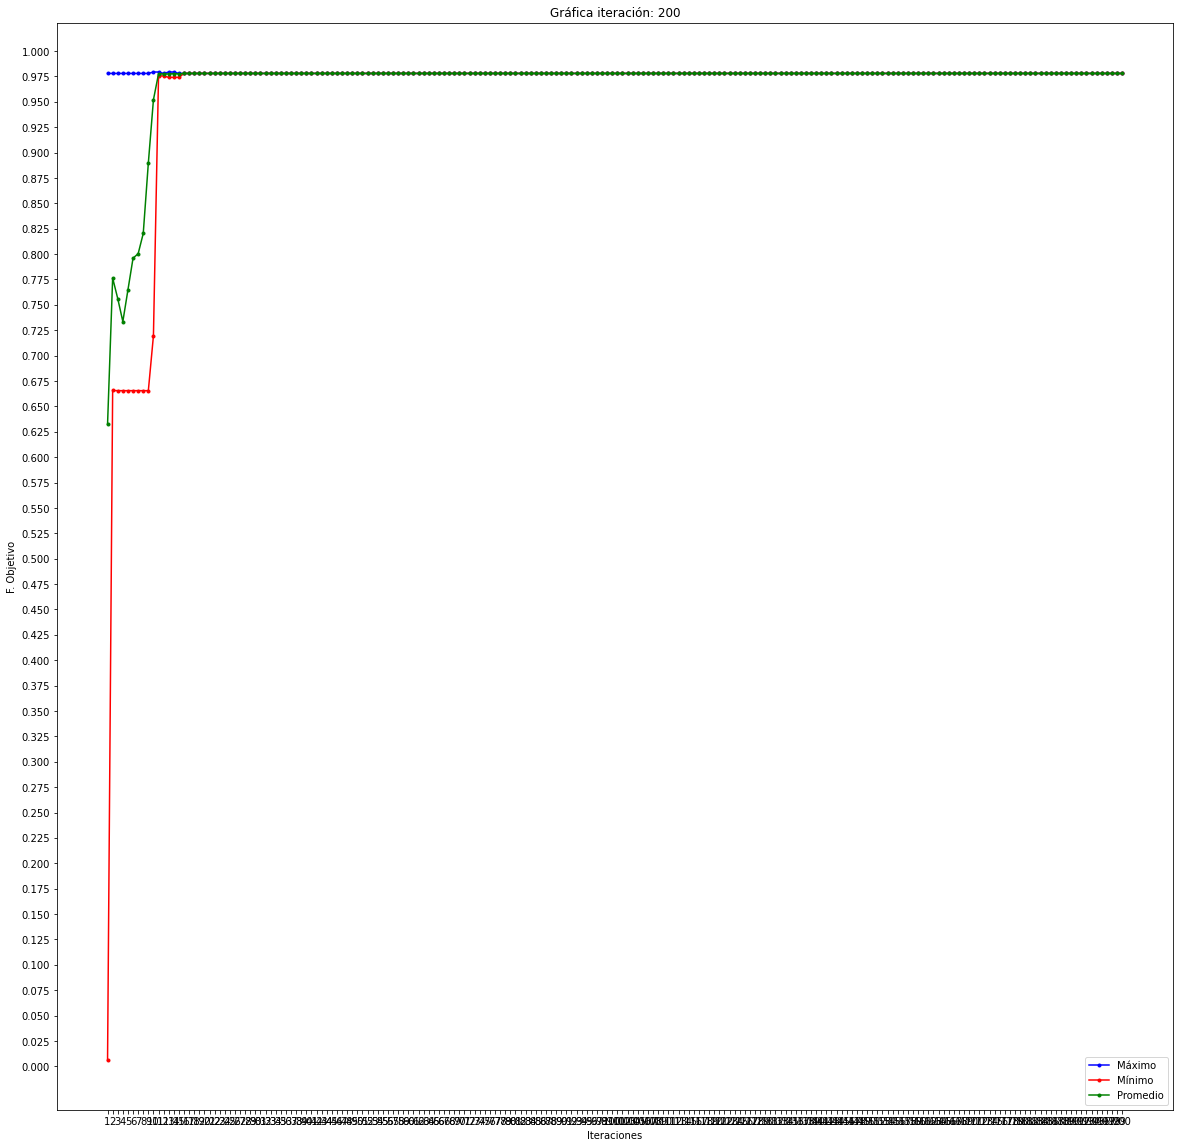

CASO B: Método selección torneo sin mutación


Iteracion,Maximo,Minimo,Promedio
1,0.872998,0.000076,0.292909
2,0.874872,0.013186,0.556631
3,0.874885,0.599099,0.819300
4,0.874885,0.874852,0.874878
5,0.874885,0.874885,0.874885
6,0.874885,0.874885,0.874885
7,0.874885,0.874885,0.874885
8,0.874885,0.874885,0.874885
9,0.874885,0.874885,0.874885
10,0.874885,0.874885,0.874885


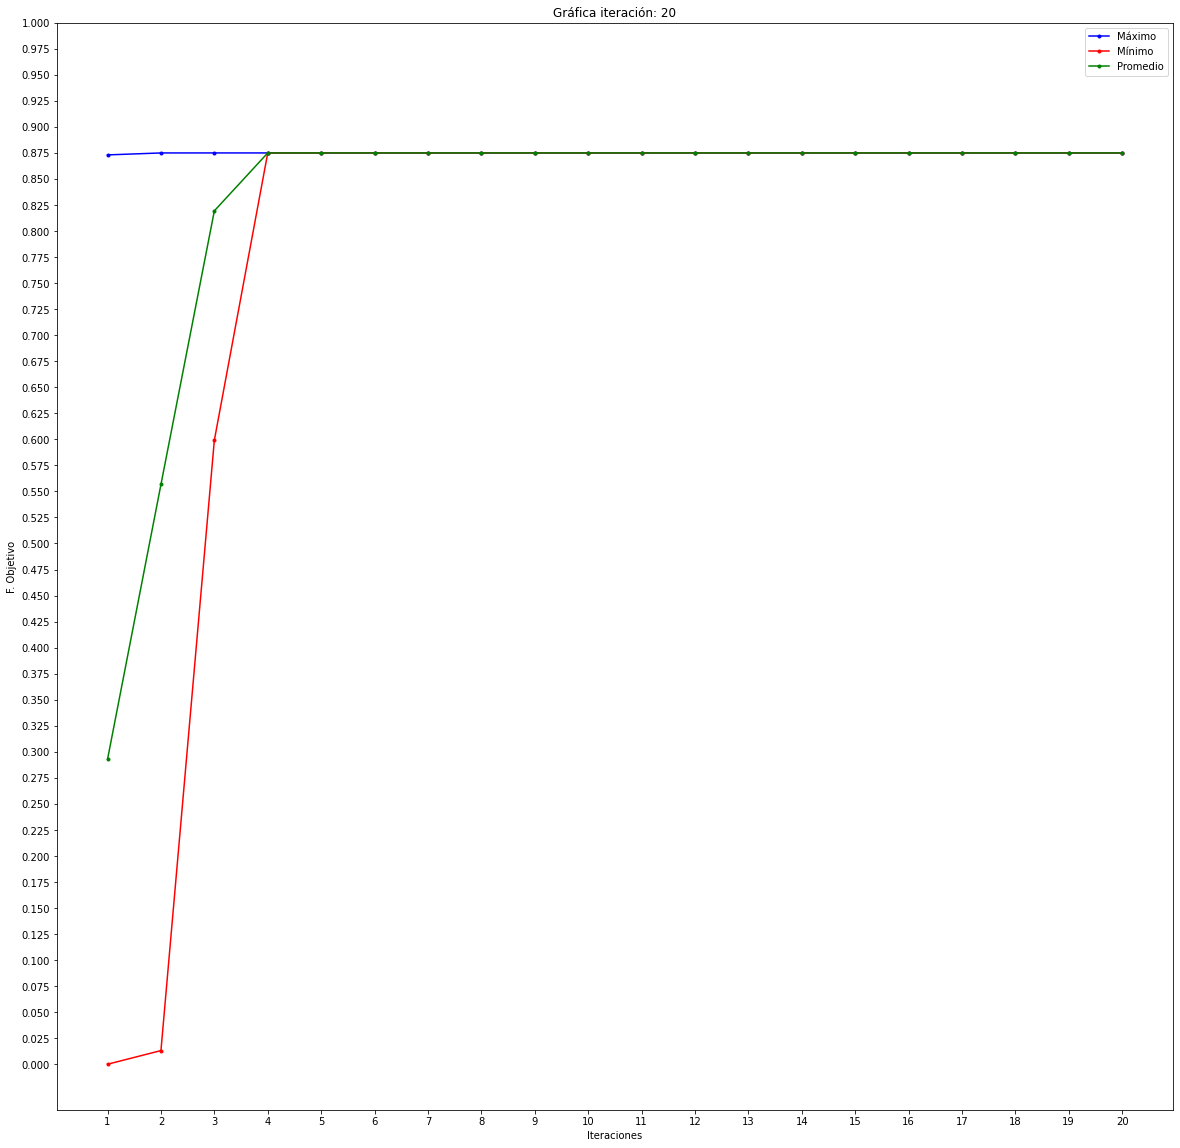

Iteracion,Maximo,Minimo,Promedio
1,0.872998,0.000076,0.292909
2,0.874872,0.013186,0.556631
3,0.874885,0.599099,0.819300
4,0.874885,0.874852,0.874878
5,0.874885,0.874885,0.874885
6,0.874885,0.874885,0.874885
7,0.874885,0.874885,0.874885
8,0.874885,0.874885,0.874885
9,0.874885,0.874885,0.874885
10,0.874885,0.874885,0.874885


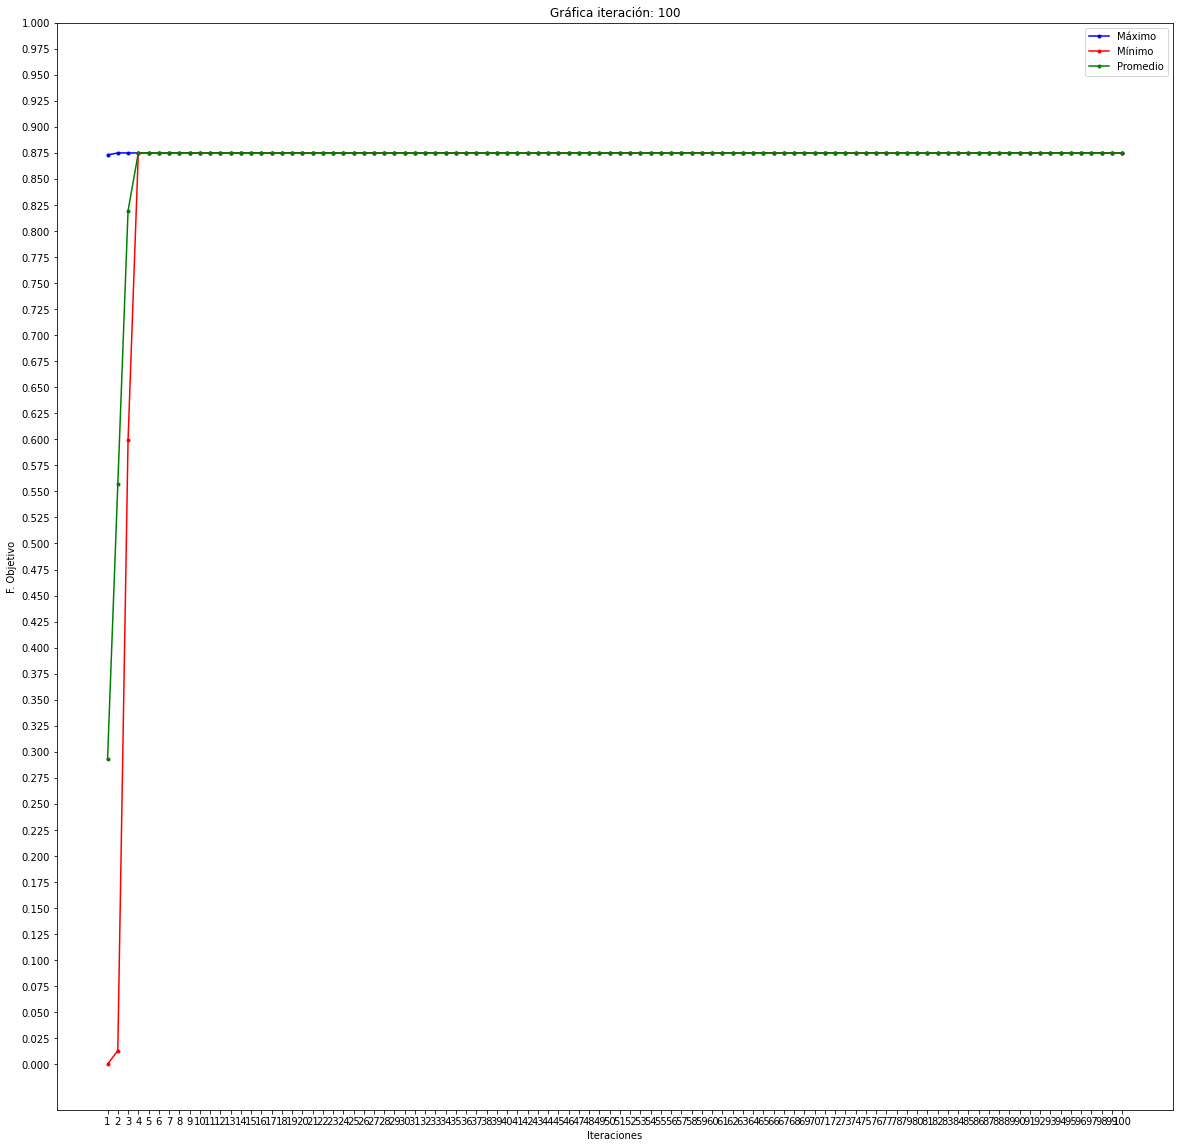

Iteracion,Maximo,Minimo,Promedio
1,0.872998,0.000076,0.292909
2,0.874872,0.013186,0.556631
3,0.874885,0.599099,0.819300
4,0.874885,0.874852,0.874878
5,0.874885,0.874885,0.874885
6,0.874885,0.874885,0.874885
7,0.874885,0.874885,0.874885
8,0.874885,0.874885,0.874885
9,0.874885,0.874885,0.874885
10,0.874885,0.874885,0.874885


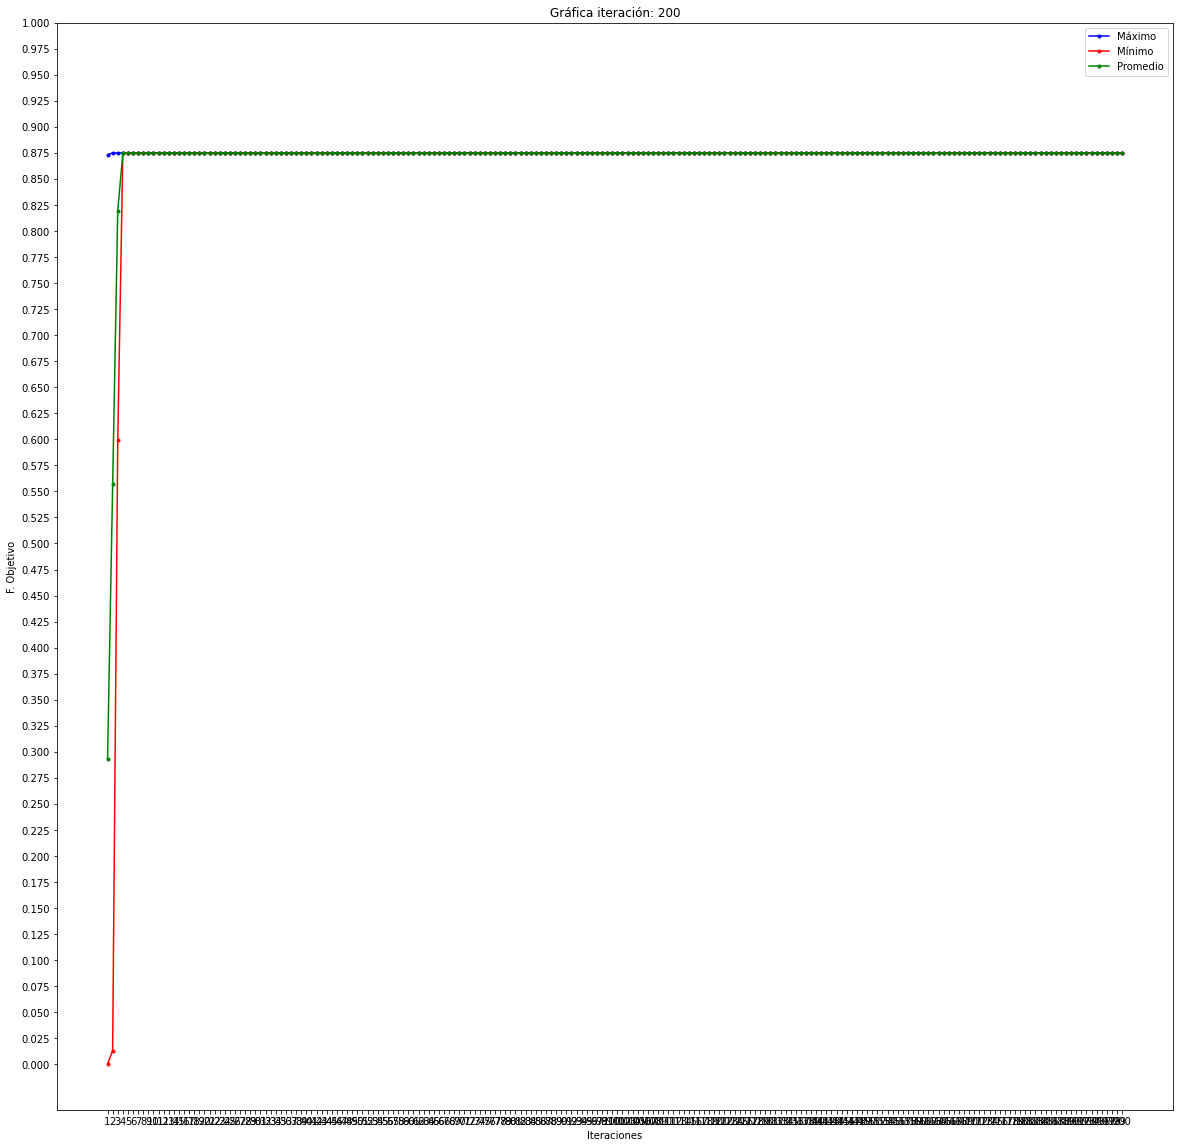

CASO C: Método selección Ruleta con elitismo sin mutación


Iteracion,Maximo,Minimo,Promedio
1,0.865659,0.010742,0.380656
2,0.865660,0.157539,0.527127
3,0.938204,0.289964,0.655515
4,0.938204,0.462955,0.790931
5,0.938204,0.462953,0.750660
6,0.938204,0.462953,0.790749
7,0.938204,0.462955,0.781376
8,0.938204,0.516232,0.762233
9,0.938204,0.516232,0.769466
10,0.938204,0.516399,0.769460


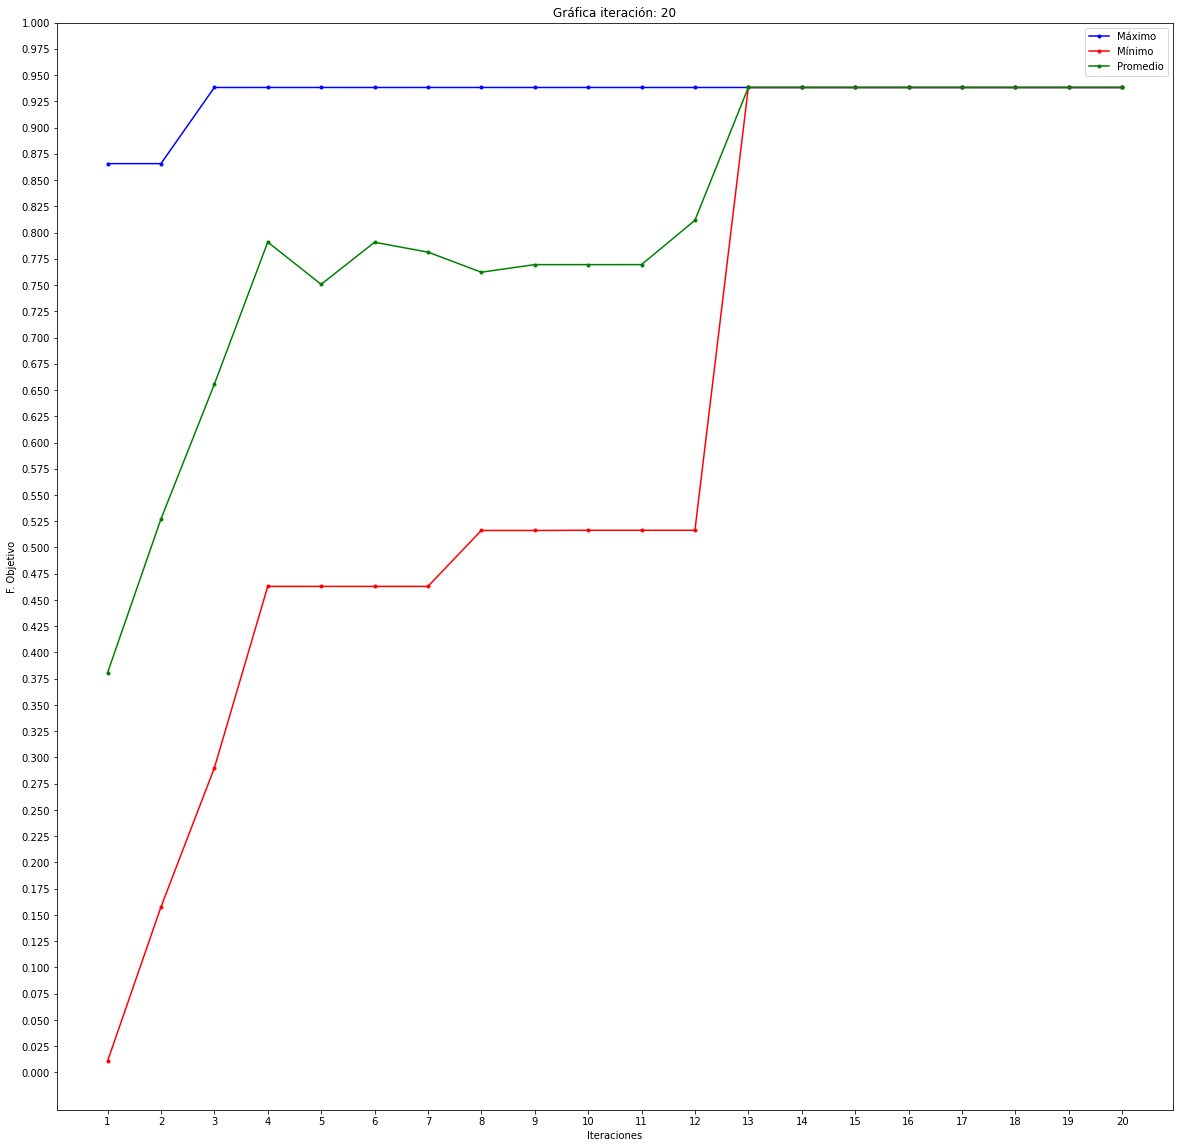

Iteracion,Maximo,Minimo,Promedio
1,0.865659,0.010742,0.380656
2,0.865660,0.157539,0.527127
3,0.938204,0.289964,0.655515
4,0.938204,0.462955,0.790931
5,0.938204,0.462953,0.750660
6,0.938204,0.462953,0.790749
7,0.938204,0.462955,0.781376
8,0.938204,0.516232,0.762233
9,0.938204,0.516232,0.769466
10,0.938204,0.516399,0.769460


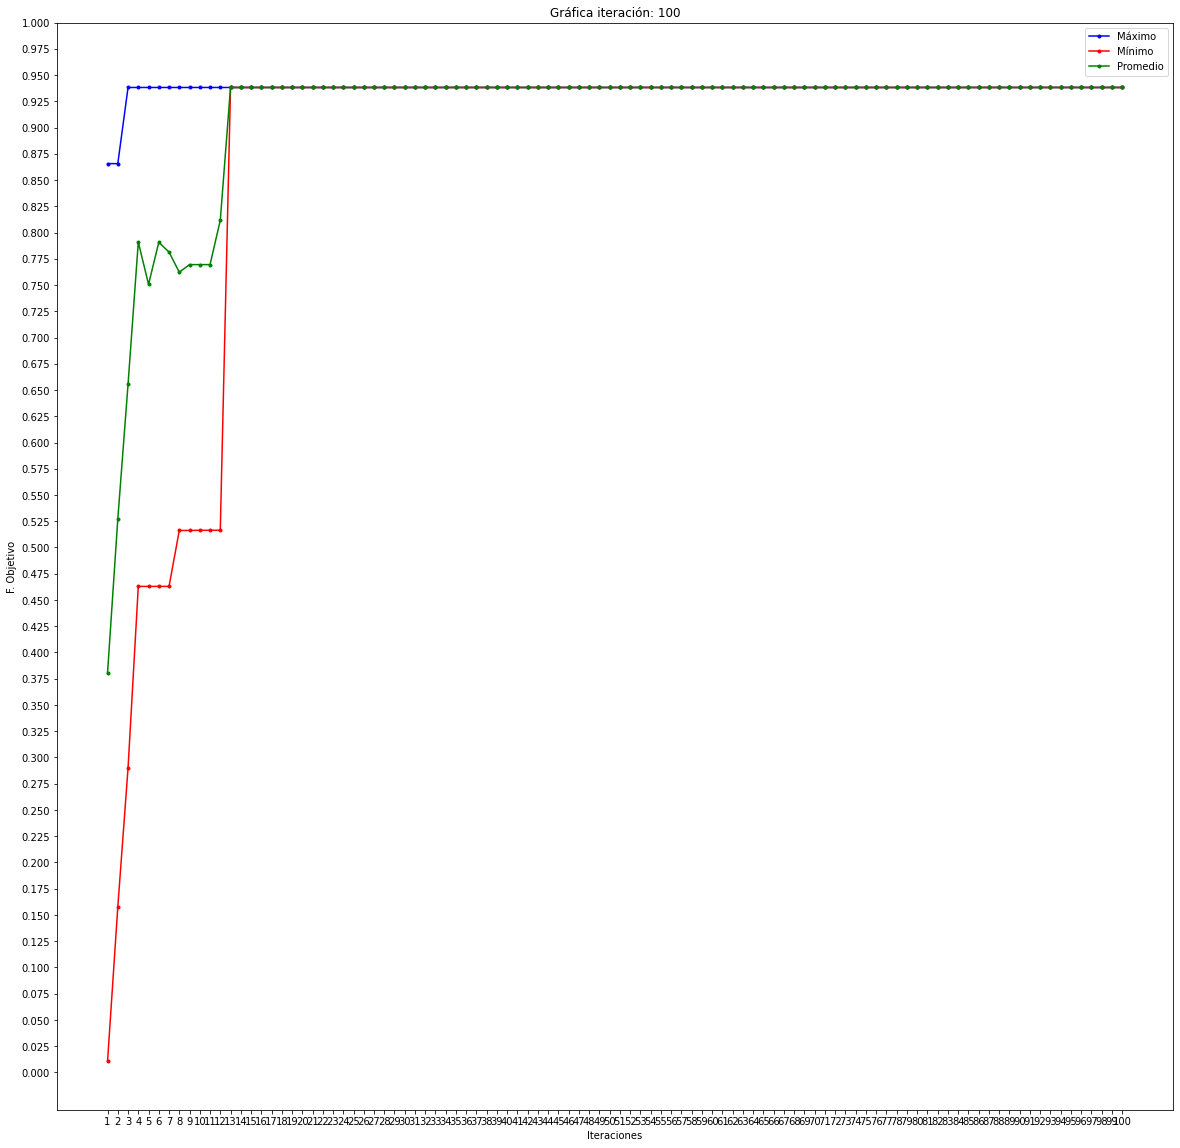

Iteracion,Maximo,Minimo,Promedio
1,0.865659,0.010742,0.380656
2,0.865660,0.157539,0.527127
3,0.938204,0.289964,0.655515
4,0.938204,0.462955,0.790931
5,0.938204,0.462953,0.750660
6,0.938204,0.462953,0.790749
7,0.938204,0.462955,0.781376
8,0.938204,0.516232,0.762233
9,0.938204,0.516232,0.769466
10,0.938204,0.516399,0.769460


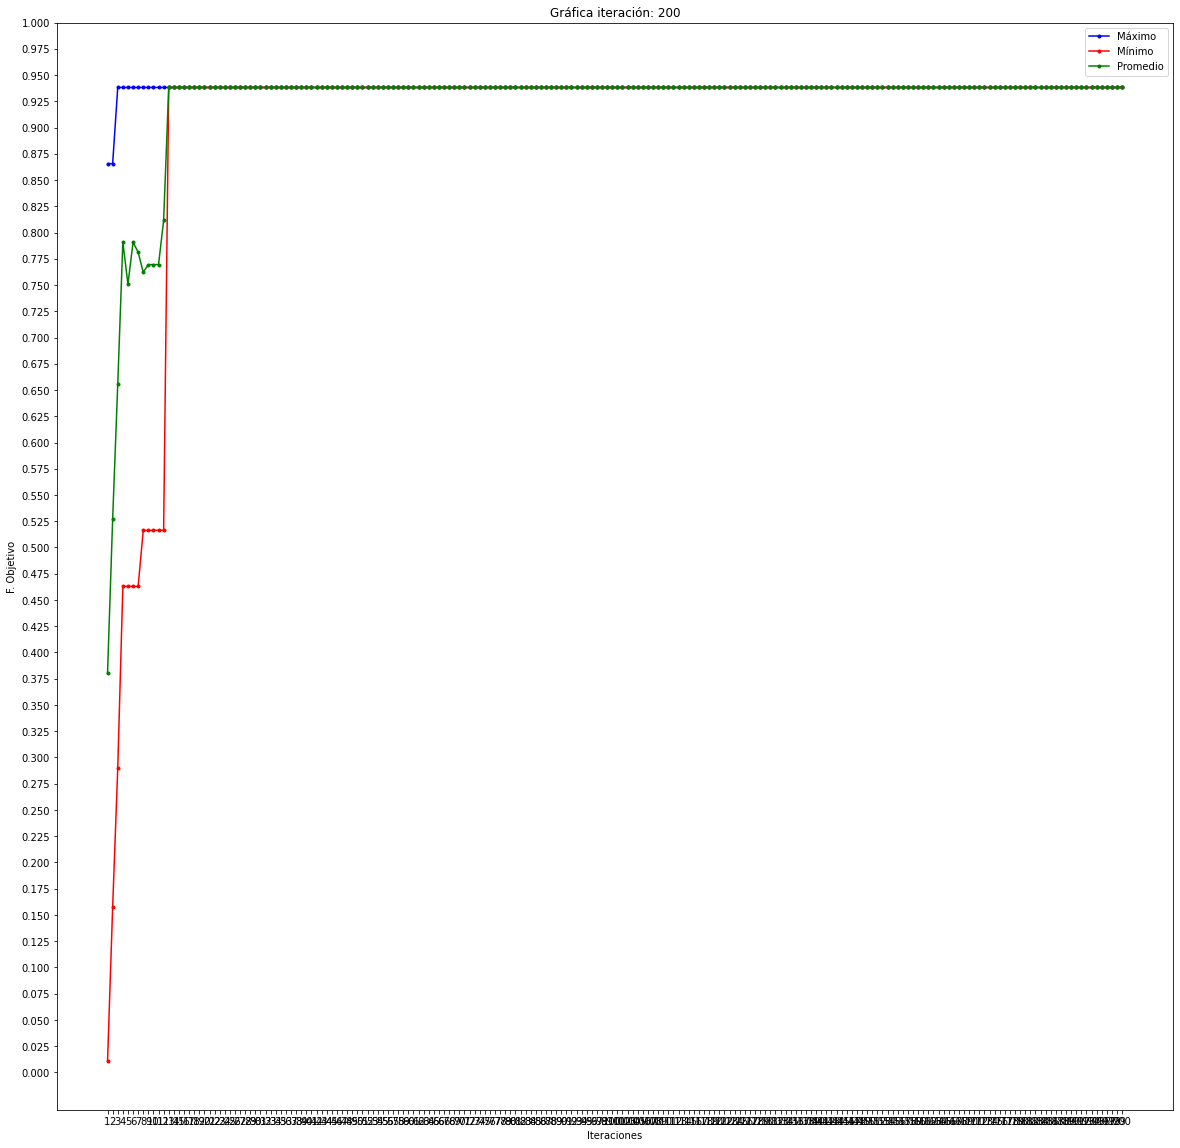

CASO C: Método selección torneo con elitismo sin mutación


Iteracion,Maximo,Minimo,Promedio
1,0.744909,0.062684,0.258942
2,0.744909,0.099582,0.431161
3,0.744909,0.351490,0.675973
4,0.744909,0.448971,0.715315
5,0.744909,0.744909,0.744909
6,0.744909,0.744909,0.744909
7,0.744909,0.744909,0.744909
8,0.744909,0.744909,0.744909
9,0.744909,0.744909,0.744909
10,0.744909,0.744909,0.744909


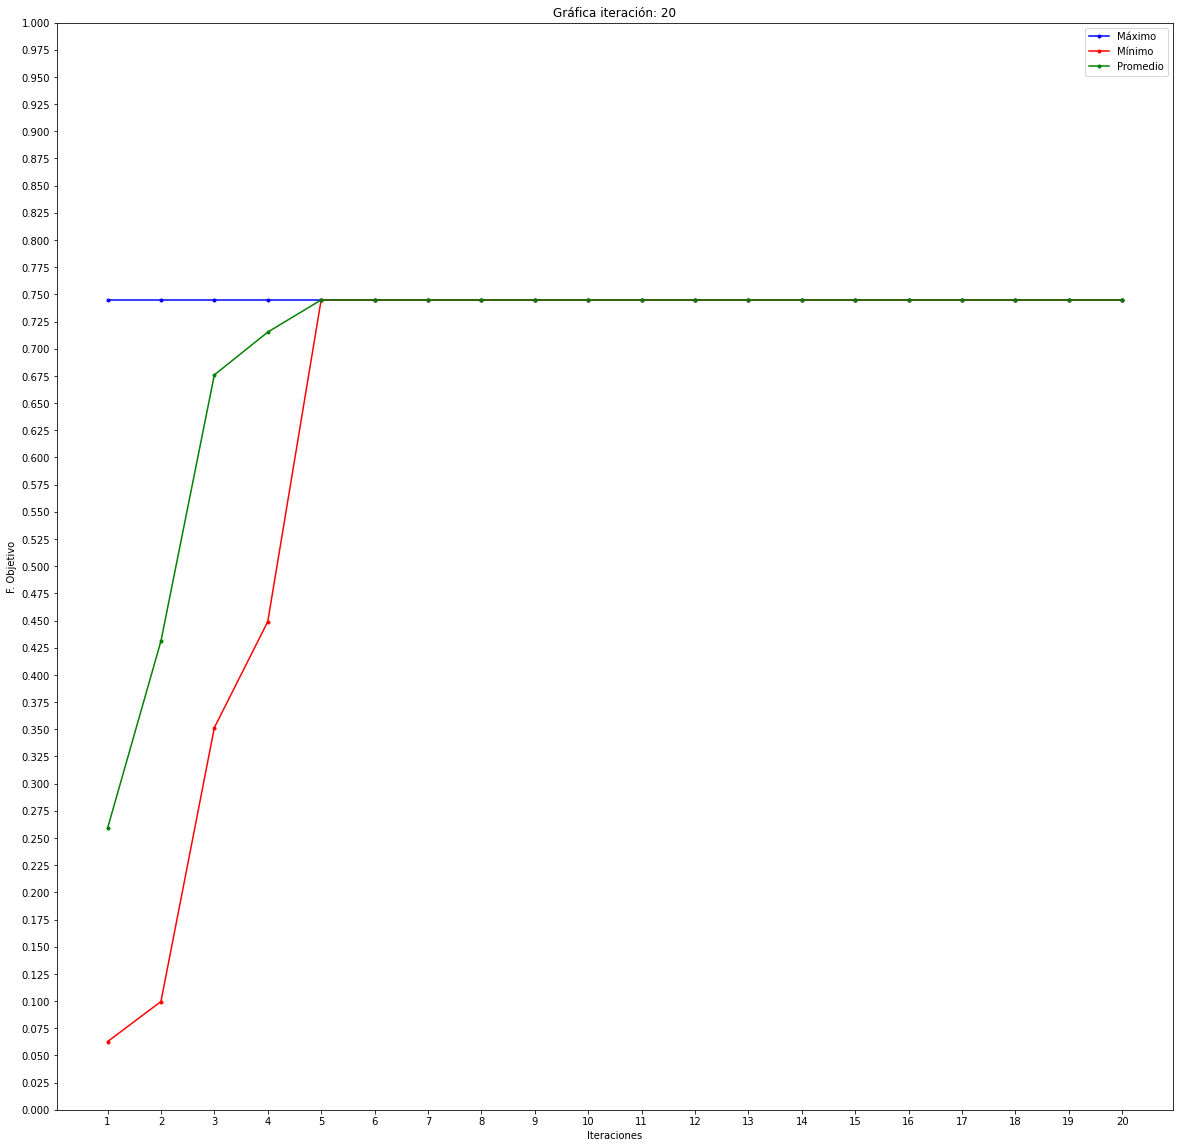

Iteracion,Maximo,Minimo,Promedio
1,0.744909,0.062684,0.258942
2,0.744909,0.099582,0.431161
3,0.744909,0.351490,0.675973
4,0.744909,0.448971,0.715315
5,0.744909,0.744909,0.744909
6,0.744909,0.744909,0.744909
7,0.744909,0.744909,0.744909
8,0.744909,0.744909,0.744909
9,0.744909,0.744909,0.744909
10,0.744909,0.744909,0.744909


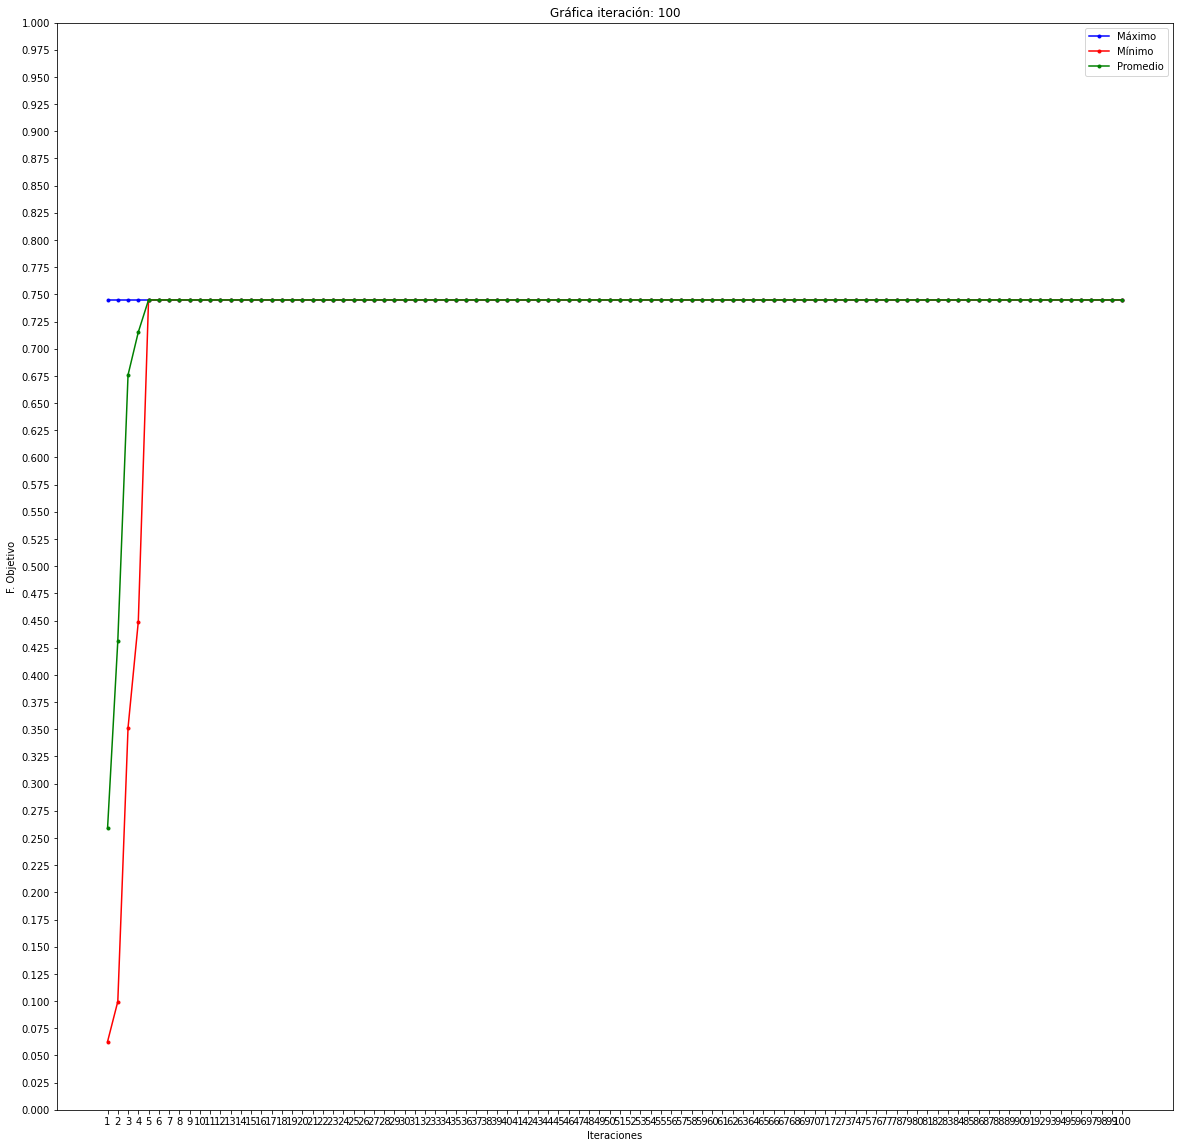

Iteracion,Maximo,Minimo,Promedio
1,0.744909,0.062684,0.258942
2,0.744909,0.099582,0.431161
3,0.744909,0.351490,0.675973
4,0.744909,0.448971,0.715315
5,0.744909,0.744909,0.744909
6,0.744909,0.744909,0.744909
7,0.744909,0.744909,0.744909
8,0.744909,0.744909,0.744909
9,0.744909,0.744909,0.744909
10,0.744909,0.744909,0.744909


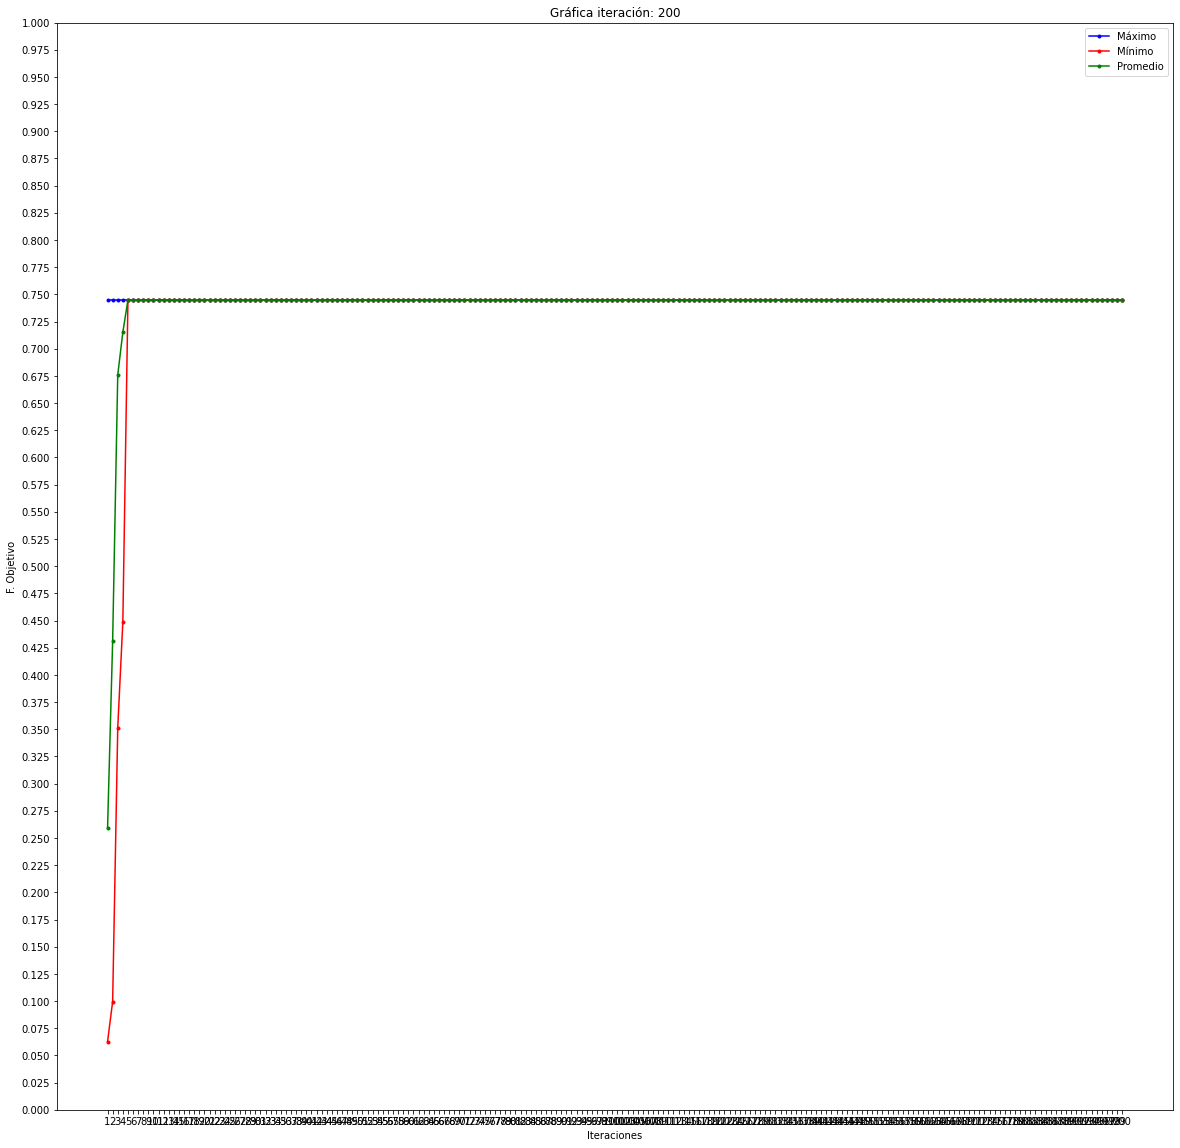

In [164]:
def main(seleccion, tieneElitismo = False, mutar = True):
    estadisticas = { "Máximo":[], "Mínimo":[], "Promedio":[]}
    poblacion_decimal = poblacionInicial()
    poblacion_binarios = convertirPoblacion(poblacion_decimal)
    for i in range(0, CICLOS):
        marcoDeDatos = generarDataFrame(poblacion_binarios, COEF)
        marcoDeDatos_stats, stats = generarEstadisticas(marcoDeDatos)
        estadisticas["Máximo"].append(stats['Máximo'][0])
        estadisticas["Mínimo"].append(stats['Mínimo'][0])
        estadisticas["Promedio"].append(stats['Promedio'][0])
        if tieneElitismo:
            elites = elitismo(poblacion_binarios, 2, COEF)
            cromosomasPadres = seleccion(poblacion_binarios, COEF, 8)
        else:
            cromosomasPadres = seleccion(poblacion_binarios,COEF, 10)
        cromosomasHijos = crossover(cromosomasPadres, PROB_CROSSOVER)
        if mutar: 
            cromosomasHijosMutados = mutacion(cromosomasHijos, PROB_MUTACION)
            if tieneElitismo: 
                poblacion_binarios = cromosomasHijosMutados + elites
            else:
                poblacion_binarios = cromosomasHijosMutados
        else:
            if tieneElitismo: 
                poblacion_binarios = cromosomasHijos + elites
            else:
                poblacion_binarios = cromosomasHijos

        if ( (i==(ITERACIONES_IMPRIMIBLES[0] - 1)) or (i==(ITERACIONES_IMPRIMIBLES[1] - 1)) or (i == (ITERACIONES_IMPRIMIBLES[2] - 1)) ): # 20, 100, 200. le resto 1 xq empieza en 0.
            marcoDeDatos = generarDataFrame(poblacion_binarios, COEF)
            marcoDeDatos_stats, stats = generarEstadisticas(marcoDeDatos)
            tabla = hacerTabla(i+1, estadisticas["Máximo"], estadisticas["Mínimo"], estadisticas["Promedio"])
            display(tabla.style.hide(axis='index'))
            #display(marcoDeDatos_stats.style.set_table_attributes("style='display:inline'").set_caption('Tabla iteración: ' + str(i+1)))
            hacerGrafico(estadisticas, i+1)

print("CASO A: Método selección ruleta")
main(ruleta)
print("CASO B: Método selección torneo")
main(torneo)
print("CASO C: Método selección Ruleta con elitismo")
main(ruleta, tieneElitismo = True)
print("CASO C: Método selección torneo con elitismo")
main(torneo, tieneElitismo = True)

# Sin mutacion (Se ve como se estanca la función en maximos locales)
print("-----------------Sin mutación-----------------")
print("CASO A: Método selección ruleta sin mutación")
main(ruleta, mutar = False)
print("CASO B: Método selección torneo sin mutación")
main(torneo, mutar = False)
print("CASO C: Método selección Ruleta con elitismo sin mutación")
main(ruleta, tieneElitismo = True, mutar = False)
print("CASO C: Método selección torneo con elitismo sin mutación")
main(torneo, tieneElitismo = True, mutar = False)